# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) \[[github](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py)\] \[[paper](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/paper/NIPS_paper_2016.pdf)\]. We refer to this VAE as the "Example VAE" in this notebook.

Other sources of inspiration:
* https://github.com/yilei0620/3D_Conditional_Gan/blob/master/ThreeD_AE.py
* https://github.com/Spartey/3D-VAE-GAN-Deep-Learning-Project/blob/master/3D-VAE-WGAN/model.py

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k(pctile=.9)
# apply filter
#thingi.filter_by_id(1351747)
thingi.filter_by_tag('animal')
#thingi.filter_to_just_one()
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_input = len(thingi)
n_input

154

In [3]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, debug=False, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.debug = debug
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        # add ops to this list as a tuple with (<op name>, <op>) to see them executed, returned, and printed
        # to console during execution
        self._debug_ops = list()
        
        # Construct the TensorFlow Graph
        self.encoder, self.enc_mu, self.enc_sig = self._make_encoder(self._input_x, self._keep_prob, self._trainable)
        self.decoder = self._make_decoder(self.encoder, self._trainable)
        self.loss, self.optimizer, self.mean_recon, self.mean_kl = self._make_loss(self._input_x, self.decoder, self.enc_mu, self.enc_sig)

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons_pre = list()
        self.recons_post = list()
        self.losses_kl_div = list()
        self.losses_recon = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
            # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
            # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
            conv1 = tf.layers.batch_normalization(tf.layers.conv3d(input_x,
                                     filters=8,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv1)
            # the Example VAE specifies the activation functions as part of the layer
            # we specify the activation function as a seperate tensor
            # it is unknown if this is the preferred method in Tensorflow, but we know
            # it works from work in the 3D-VAE-GAN notebook
            # we also take advantage of batch_normalization
            # more info here:
            # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
            # with the hope that it gives speed without sacrificing quality
            # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
            # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu

            conv2 = tf.layers.batch_normalization(tf.layers.conv3d(conv1,
                                     filters=16,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv2)

            conv3 = tf.layers.batch_normalization(tf.layers.conv3d(conv2,
                                     filters=32,
                                     kernel_size=[3, 3, 3],
                                     strides=(1, 1, 1),
                                     padding='valid',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv3)

            conv4 = tf.layers.batch_normalization(tf.layers.conv3d(conv3,
                                     filters=64,
                                     kernel_size=[3, 3, 3],
                                     strides=(2, 2, 2),
                                     padding='same',
                                     activation=tf.nn.elu,
                                     kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(conv4)

            # Apply one fully-connected layer after Conv3d layers
            # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
            dense1 = tf.layers.batch_normalization(tf.layers.dense(conv4,
                                 units=343,
                                 activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform()))
            self._print_shape(dense1)
            flatten = tf.layers.flatten(tf.nn.dropout(dense1, keep_prob))
        
            enc_mu = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_mu)
            enc_sig = tf.layers.batch_normalization(tf.layers.dense(flatten,
                                 units=self.latent_dim,
                                 activation=None))
            self._print_shape(enc_sig)
                                                  
            # epsilon is a random draw from the latent space
            epsilon = tf.random_normal(tf.stack([tf.shape(dense1)[0], self.latent_dim]))
            self._print_shape(epsilon, 'epsilon')
            enc_z = enc_mu + tf.multiply(epsilon, tf.exp(enc_sig))
            self._print_shape(enc_z, 'z')
        return enc_z, enc_mu, enc_sig


        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')

        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')

        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu5,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = tf.clip_by_value(decoded_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max decoded_output', tf.math.reduce_max(decoded_output), False)
        #self._add_debug_op('min decoded_output', tf.math.reduce_min(decoded_output), False)
        #self._add_debug_op('mean decoded_output', tf.math.reduce_mean(decoded_output), False)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        
        # Weighted binary cross-entropy for use in voxel loss. Allows weighting of false positives relative to false negatives.
        # Nominally set to strongly penalize false negatives
        # we must clip because values of 0 or 1 will cause errors
        #clipped_input = tf.clip_by_value(tf.nn.sigmoid(enc_input), 1e-7, 1.0 - 1e-7)
        clipped_input = tf.clip_by_value(enc_input, 1e-7, 1.0 - 1e-7)
        clipped_output = tf.clip_by_value(dec_output, 1e-7, 1.0 - 1e-7)
        #self._add_debug_op('max clipped_input', tf.math.reduce_max(clipped_input), False)
        #self._add_debug_op('min clipped_input', tf.math.reduce_min(clipped_input), False)
        #self._add_debug_op('mean clipped_input', tf.math.reduce_mean(clipped_input), False)
        self._add_debug_op('max clipped_output', tf.math.reduce_max(clipped_output), False)
        self._add_debug_op('min clipped_output', tf.math.reduce_min(clipped_output), False)
        self._add_debug_op('mean clipped_output', tf.math.reduce_mean(clipped_output), False)
        bce = -(98.0 * clipped_input * tf.log(clipped_output) + 2.0 * (1.0 - clipped_input) * tf.log(1.0 - clipped_output)) / 100.0
        #self._add_debug_op('bce', bce, False)
        #bce = tf.keras.backend.binary_crossentropy(enc_output, dec_output)
        
        # Voxel-Wise Reconstruction Loss 
        # Note that the output values are clipped to prevent the BCE from evaluating log(0).
        recon_loss = tf.reduce_mean(bce, 1)
   
        #recon_loss = tf.reduce_sum(tf.squared_difference(
        #    tf.reshape(dec_output, (-1, self.input_dim ** 3)),
        #    tf.reshape(self._input_x, (-1, self.input_dim ** 3))), 1)
        
        kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_kl = tf.reduce_sum(kl_divergence)
        #self._add_debug_op('mean_kl', mean_kl, False)
        mean_recon = tf.reduce_sum(recon_loss)
        #self._add_debug_op('mean_recon', mean_recon, False)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * kl_divergence + self.recon_loss_weight * recon_loss)
        #self._add_debug_op('loss', loss, False)
        # remove kl for fun
        #loss = tf.reduce_mean(self.recon_loss_weight * recon_loss)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

        return loss, optimizer, mean_recon, mean_kl

    def _add_debug_op(self, name, op, newline=True):
        self._debug_ops.append((name, op, newline))
        return

    def _print_debug_ops(self, results):
        if self.debug:
            for i, debug_op in enumerate(self._debug_ops):
                msg = 'DEBUG_OP "{}": '.format(debug_op[0])
                if len(debug_op) > 2 and debug_op[2]:
                    msg += '\n'
                msg += '{}'.format(results[i])
                print(msg)
        return

    def train(self, generator, epochs=10, input_repeats=1, display_step=1, save_step=1, viz_data=None):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                if self.verbose:
                    print('Epoch: {}, Batch: {}, Elapsed time: {:.2f} mins'.format(epoch_num, batch_num, (time.time() - start) / 60))
                #print("batch.min()", batch.min())
                #print("batch.max()", batch.max())
                # repeat for extra practice on each shape
                for _ in range(input_repeats):

                    ops = tuple([self.optimizer, self.loss, self.mean_kl, self.mean_recon] + 
                                [op for name, op, _ in self._debug_ops])
                    results = self.sess.run(
                        ops,
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                    _, loss, kl_divergence, recon_loss = results[:4]
                    self._print_debug_ops(results[4:])
                    
                if self.verbose:
                    #print('\tKL Divergence = {:.5f}, Reconstruction Loss = {:.5f}'.format(kl_divergence, recon_loss))
                    print('\tKL Divergence = {}, Reconstruction Loss = {}'.format(kl_divergence, recon_loss))
                
            if (epoch + 1) % display_step == 0:
                print("Epoch: {}, ".format(epoch + 1) + 
                      "Loss = {:.5f}, ".format(loss) + 
                      "KL Divergence = {:.5f}, ".format(kl_divergence) +
                      "Reconstruction Loss = {:.5f}, ".format(recon_loss) +
                      "Elapsed time: {:.2f} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                if viz_data is not None:
                    self._print_shape(viz_data, 'Example shape (before reshape)')
                    recon_input = np.reshape(viz_data, (1, self.input_dim, self.input_dim, self.input_dim, 1))
                    self._print_shape(recon_input, 'Example shape')

                    # generate!
                    recon = self.reconstruct(recon_input)
                    self._print_shape(recon, 'Recon')

                    # prepare for plotting
                    recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon_input, 'Example shape (for plotting)')
                    recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                    self._print_shape(recon, 'Recon (for plotting)')
                    # network outputs decimals; here we force them to True/False for plotting
                    self.recons_pre.append(recon)
                    recon = recon > 0.5
                    self.recons_post.append(recon)
                    # replace all nans with zeros
                    #recon = np.nan_to_num(recon)

                    # save the generated object in case we wish to review later
                    path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))

                    # visualize
                    self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        ops = tuple([self.decoder] + [op for name, op, _ in self._debug_ops])
                    
        results = self.sess.run(ops, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        
        decoded = results[0]
        self._print_debug_ops(results[1:])
                    
        return decoded
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


## Training

The model is having issues producing an output that is recognizable.

Experiments:
* Large & small datasets produce the same result
* latent_dim variations have no effect
* Too high of a learning rate causes the loss to go down then up and sometimes fluctuate
* Removing dropout (keep_prob=1.0) with lr=0.00001 on a single training example causes loss to go down as expected but output is still not recognizable
* Upping recon_loss_weight seems to cause more variation in decoded output
* Severe upping of recon_loss_weight (recon=5, kl=5e-4) delivered loss of ~5 after 500 epochs on a single training example with 20 input_repeats
* 500 epochs with above settings and RMSPropOptimizer achieved loss of <1 after about 200 epochs; viz still unimpressive
* Increasing recon_loss_weight to 5e5 and dumping recon loss and kl divergence values reveals that recon loss is diminishing. Question: what is the input to recon loss? an array of 1s and 0s or TRUEs and FALSEs? A: 1s and 0s
* Using weight binary cross entropy for recon loss as according to Example VAE shows same loss reduction pattern with still unimpressive recon
* Equalized loss weights yielded no change (at 100 epochs on one square example with 50 input_repeats, viz was all 1s)
* By dumping out counts of True vs False of each recon, I can see that False goes down while True goes up to the point where they are almost all Trues after 50 epochs
* Run through all training examples produces loss of nan
* Added homebaked debug_ops and discovered that the dec_output is nan and not the loss functions!
* latent_dim=100, lr=0.0001, dataset=animals, keep_prob=1.0, kl_loss_weight=1, recon_loss_weight=1e4, batch_size=22, epochs=50 -- kind of reconstructed 126660 the bird! Used a threshold of 0.085 though.

Notes:

* The model is assigning a high probability to the outside layer of the cube. As you decrease the threshold, that outside layer begins to build. Why? How many training examples even have voxels in those locations? 
* You would expect the center voxel to always have the highest probability as all input is centered and thus would fill that voxel.

Todo:
* Move model into .py file
* Move training config into .py file that can be edited/saved
* Improve model saving/restoring/labeling
* *Combine VAE with GAN for VAE-GAN!*

Num input = 154
Num batches per epoch = 7.00


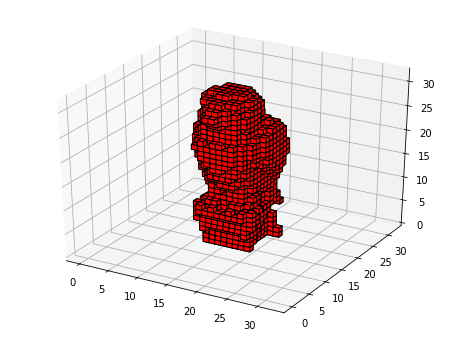

In [4]:
VOXELS_DIM = 32
BATCH_SIZE = 22
print('Num input = {}'.format(n_input))
print('Num batches per epoch = {:.2f}'.format(n_input / BATCH_SIZE))
training_example = thingi.get_voxels(VOXELS_DIM, stl_file=thingi.get_stl_path(stl_id=126660))
plot_voxels(training_example)

encoder/batch_normalization/batchnorm/add_1:0: (?, 30, 30, 30, 8)
encoder/batch_normalization_1/batchnorm/add_1:0: (?, 15, 15, 15, 16)
encoder/batch_normalization_2/batchnorm/add_1:0: (?, 13, 13, 13, 32)
encoder/batch_normalization_3/batchnorm/add_1:0: (?, 7, 7, 7, 64)
encoder/batch_normalization_4/batchnorm/add_1:0: (?, 7, 7, 7, 343)
encoder/batch_normalization_5/batchnorm/add_1:0: (?, 100)
encoder/batch_normalization_6/batchnorm/add_1:0: (?, 100)
epsilon: (?, 100)
z: (?, 100)
input_z: (?, 100)
dec_dense1/BiasAdd:0: (?, 343)
Elu:0: (?, 343)
reshape_z:0: (?, 7, 7, 7, 1)
dec_conv1/conv3d_transpose:0: (?, 7, 7, 7, 64)
dec_lrelu2:0: (?, 7, 7, 7, 64)
dec_conv2/conv3d_transpose:0: (?, 15, 15, 15, 32)
dec_lrelu3:0: (?, 15, 15, 15, 32)
dec_conv3/conv3d_transpose:0: (?, 15, 15, 15, 16)
dec_lrelu4:0: (?, 15, 15, 15, 16)
dec_conv4/conv3d_transpose:0: (?, 32, 32, 32, 8)
dec_lrelu5:0: (?, 32, 32, 32, 8)
dec_conv5/conv3d_transpose:0: (?, 32, 32, 32, 1)
Sigmoid:0: (?, 32, 32, 32, 1)
Epoch: 0, Batch:

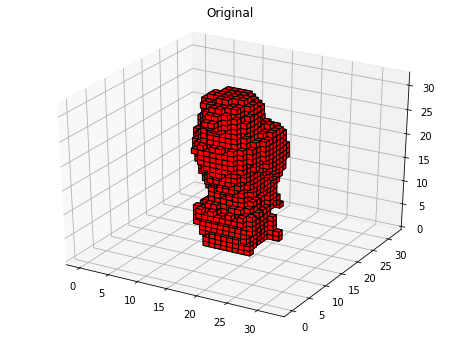

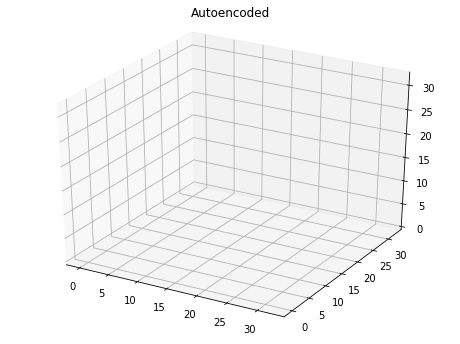

Epoch: 1, Batch: 0, Elapsed time: 0.14 mins
DEBUG_OP "max clipped_output": 0.9999996423721313
DEBUG_OP "min clipped_output": 0.08731329441070557
DEBUG_OP "mean clipped_output": 0.7450866103172302
	KL Divergence = 129.51278686523438, Reconstruction Loss = 962.5751953125
Epoch: 1, Batch: 1, Elapsed time: 0.15 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.13034461438655853
DEBUG_OP "mean clipped_output": 0.6948341727256775
	KL Divergence = 162.22705078125, Reconstruction Loss = 939.085693359375
Epoch: 1, Batch: 2, Elapsed time: 0.16 mins
DEBUG_OP "max clipped_output": 0.9999998807907104
DEBUG_OP "min clipped_output": 0.10691450536251068
DEBUG_OP "mean clipped_output": 0.6558287739753723
	KL Divergence = 210.74310302734375, Reconstruction Loss = 970.4984741210938
Epoch: 1, Batch: 3, Elapsed time: 0.18 mins
DEBUG_OP "max clipped_output": 0.9999556541442871
DEBUG_OP "min clipped_output": 0.11136335879564285
DEBUG_OP "mean clipped_output": 0.696808755

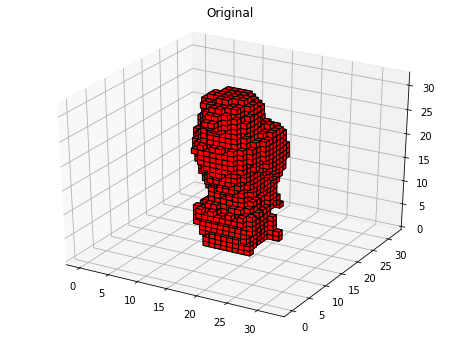

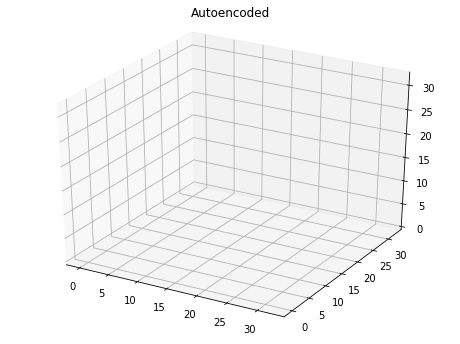

Epoch: 2, Batch: 0, Elapsed time: 0.27 mins
DEBUG_OP "max clipped_output": 0.9999734163284302
DEBUG_OP "min clipped_output": 0.08993304520845413
DEBUG_OP "mean clipped_output": 0.6613457202911377
	KL Divergence = 124.55270385742188, Reconstruction Loss = 861.0006103515625
Epoch: 2, Batch: 1, Elapsed time: 0.28 mins
DEBUG_OP "max clipped_output": 0.9999829530715942
DEBUG_OP "min clipped_output": 0.08197727799415588
DEBUG_OP "mean clipped_output": 0.6587936878204346
	KL Divergence = 134.47698974609375, Reconstruction Loss = 905.36669921875
Epoch: 2, Batch: 2, Elapsed time: 0.29 mins
DEBUG_OP "max clipped_output": 0.9999923706054688
DEBUG_OP "min clipped_output": 0.10093057155609131
DEBUG_OP "mean clipped_output": 0.6610787510871887
	KL Divergence = 151.02346801757812, Reconstruction Loss = 884.87841796875
Epoch: 2, Batch: 3, Elapsed time: 0.31 mins
DEBUG_OP "max clipped_output": 0.9999909400939941
DEBUG_OP "min clipped_output": 0.1299103945493698
DEBUG_OP "mean clipped_output": 0.6815827

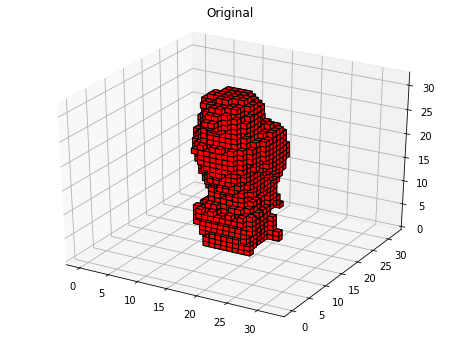

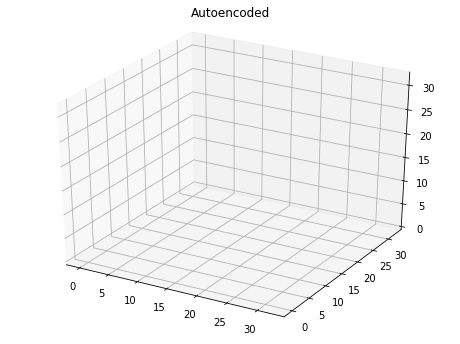

Epoch: 3, Batch: 0, Elapsed time: 0.40 mins
DEBUG_OP "max clipped_output": 0.9999991655349731
DEBUG_OP "min clipped_output": 0.059306543320417404
DEBUG_OP "mean clipped_output": 0.6338790655136108
	KL Divergence = 304.7239074707031, Reconstruction Loss = 794.2412719726562
Epoch: 3, Batch: 1, Elapsed time: 0.41 mins
DEBUG_OP "max clipped_output": 0.9999954700469971
DEBUG_OP "min clipped_output": 0.06539358198642731
DEBUG_OP "mean clipped_output": 0.6243613362312317
	KL Divergence = 267.2242431640625, Reconstruction Loss = 824.8768920898438
Epoch: 3, Batch: 2, Elapsed time: 0.43 mins
DEBUG_OP "max clipped_output": 0.9999978542327881
DEBUG_OP "min clipped_output": 0.06576844304800034
DEBUG_OP "mean clipped_output": 0.6189004182815552
	KL Divergence = 248.13734436035156, Reconstruction Loss = 806.7471923828125
Epoch: 3, Batch: 3, Elapsed time: 0.44 mins
DEBUG_OP "max clipped_output": 0.99998939037323
DEBUG_OP "min clipped_output": 0.08543740212917328
DEBUG_OP "mean clipped_output": 0.62241

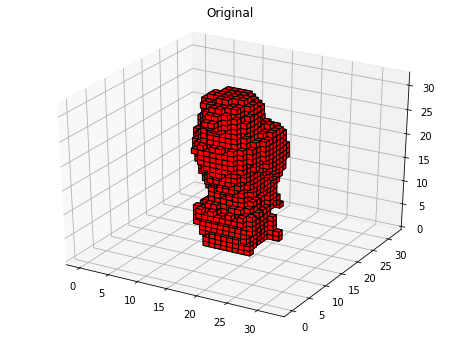

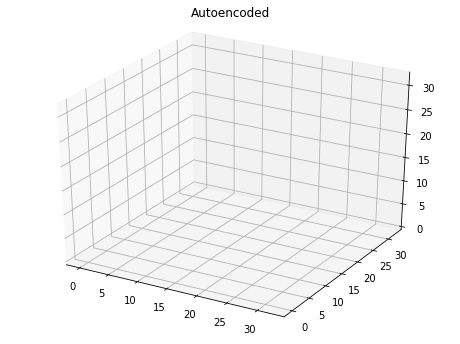

Epoch: 4, Batch: 0, Elapsed time: 0.53 mins
DEBUG_OP "max clipped_output": 0.9999897480010986
DEBUG_OP "min clipped_output": 0.06119268015027046
DEBUG_OP "mean clipped_output": 0.6065393090248108
	KL Divergence = 491.8560485839844, Reconstruction Loss = 705.3304443359375
Epoch: 4, Batch: 1, Elapsed time: 0.54 mins
DEBUG_OP "max clipped_output": 0.9999960660934448
DEBUG_OP "min clipped_output": 0.057723626494407654
DEBUG_OP "mean clipped_output": 0.599837064743042
	KL Divergence = 446.290283203125, Reconstruction Loss = 757.97705078125
Epoch: 4, Batch: 2, Elapsed time: 0.56 mins
DEBUG_OP "max clipped_output": 0.9999295473098755
DEBUG_OP "min clipped_output": 0.05248282104730606
DEBUG_OP "mean clipped_output": 0.5849576592445374
	KL Divergence = 465.8809814453125, Reconstruction Loss = 697.861328125
Epoch: 4, Batch: 3, Elapsed time: 0.57 mins
DEBUG_OP "max clipped_output": 0.9999940395355225
DEBUG_OP "min clipped_output": 0.03701459616422653
DEBUG_OP "mean clipped_output": 0.572759747505

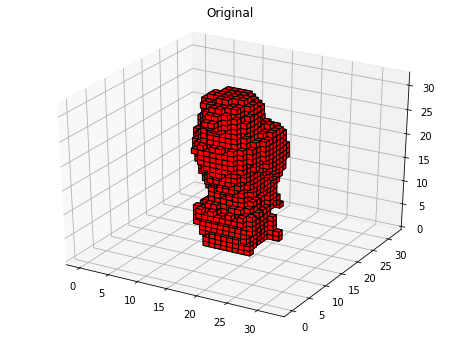

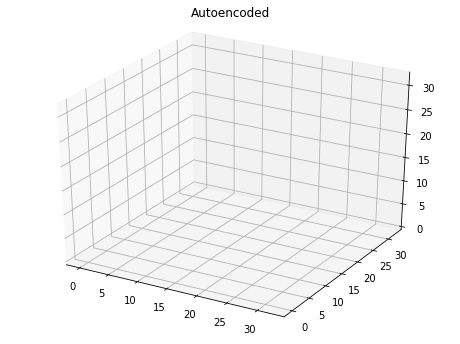

Epoch: 5, Batch: 0, Elapsed time: 0.66 mins
DEBUG_OP "max clipped_output": 0.9999467134475708
DEBUG_OP "min clipped_output": 0.04159429669380188
DEBUG_OP "mean clipped_output": 0.5692129135131836
	KL Divergence = 635.36669921875, Reconstruction Loss = 669.6280517578125
Epoch: 5, Batch: 1, Elapsed time: 0.68 mins
DEBUG_OP "max clipped_output": 0.9999786615371704
DEBUG_OP "min clipped_output": 0.03212304785847664
DEBUG_OP "mean clipped_output": 0.5585407614707947
	KL Divergence = 607.9814453125, Reconstruction Loss = 721.9325561523438
Epoch: 5, Batch: 2, Elapsed time: 0.69 mins
DEBUG_OP "max clipped_output": 0.9999774694442749
DEBUG_OP "min clipped_output": 0.040301013737916946
DEBUG_OP "mean clipped_output": 0.5509222149848938
	KL Divergence = 686.372802734375, Reconstruction Loss = 686.46044921875
Epoch: 5, Batch: 3, Elapsed time: 0.71 mins
DEBUG_OP "max clipped_output": 0.9999690055847168
DEBUG_OP "min clipped_output": 0.03252286836504936
DEBUG_OP "mean clipped_output": 0.561092555522

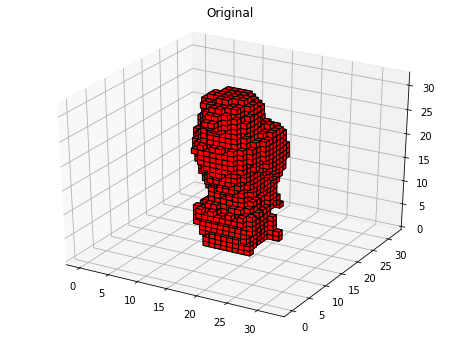

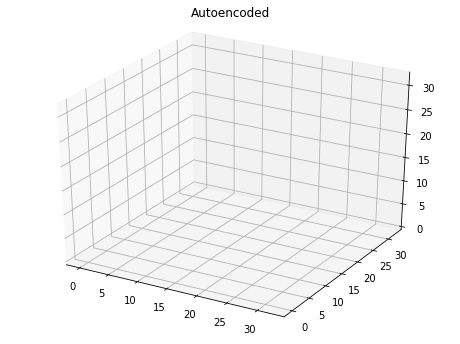

Epoch: 6, Batch: 0, Elapsed time: 0.80 mins
DEBUG_OP "max clipped_output": 0.9997935891151428
DEBUG_OP "min clipped_output": 0.02851666696369648
DEBUG_OP "mean clipped_output": 0.5841537714004517
	KL Divergence = 322.348388671875, Reconstruction Loss = 708.12255859375
Epoch: 6, Batch: 1, Elapsed time: 0.81 mins
DEBUG_OP "max clipped_output": 0.9996227025985718
DEBUG_OP "min clipped_output": 0.03832993283867836
DEBUG_OP "mean clipped_output": 0.5797269344329834
	KL Divergence = 496.2616882324219, Reconstruction Loss = 722.3008422851562
Epoch: 6, Batch: 2, Elapsed time: 0.83 mins
DEBUG_OP "max clipped_output": 0.999630331993103
DEBUG_OP "min clipped_output": 0.031777702271938324
DEBUG_OP "mean clipped_output": 0.5790278315544128
	KL Divergence = 497.8743896484375, Reconstruction Loss = 712.3653564453125
Epoch: 6, Batch: 3, Elapsed time: 0.84 mins
DEBUG_OP "max clipped_output": 0.999977707862854
DEBUG_OP "min clipped_output": 0.034876056015491486
DEBUG_OP "mean clipped_output": 0.56870198

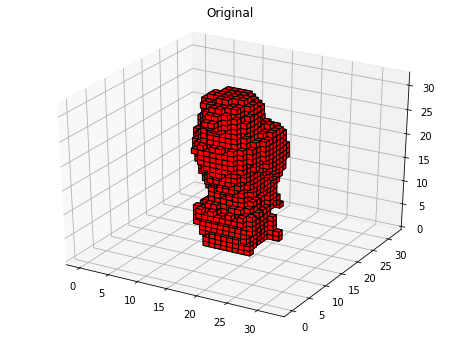

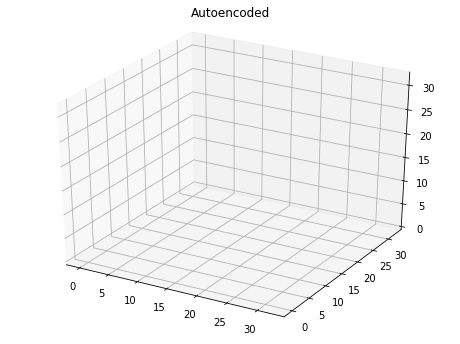

Epoch: 7, Batch: 0, Elapsed time: 0.93 mins
DEBUG_OP "max clipped_output": 0.9999843835830688
DEBUG_OP "min clipped_output": 0.015045816078782082
DEBUG_OP "mean clipped_output": 0.5394710898399353
	KL Divergence = 630.6024169921875, Reconstruction Loss = 605.2731323242188
Epoch: 7, Batch: 1, Elapsed time: 0.94 mins
DEBUG_OP "max clipped_output": 0.9999825954437256
DEBUG_OP "min clipped_output": 0.013564599677920341
DEBUG_OP "mean clipped_output": 0.5174481272697449
	KL Divergence = 640.9524536132812, Reconstruction Loss = 666.757568359375
Epoch: 7, Batch: 2, Elapsed time: 0.96 mins
DEBUG_OP "max clipped_output": 0.9999215602874756
DEBUG_OP "min clipped_output": 0.0127403000369668
DEBUG_OP "mean clipped_output": 0.5078339576721191
	KL Divergence = 752.184814453125, Reconstruction Loss = 587.6770629882812
Epoch: 7, Batch: 3, Elapsed time: 0.97 mins
DEBUG_OP "max clipped_output": 0.9999748468399048
DEBUG_OP "min clipped_output": 0.010886624455451965
DEBUG_OP "mean clipped_output": 0.49905

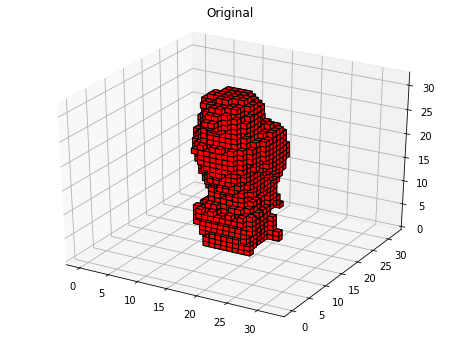

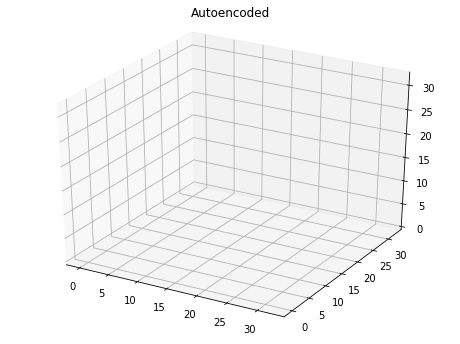

Epoch: 8, Batch: 0, Elapsed time: 1.07 mins
DEBUG_OP "max clipped_output": 0.9999116659164429
DEBUG_OP "min clipped_output": 0.006527781952172518
DEBUG_OP "mean clipped_output": 0.4883318841457367
	KL Divergence = 600.1551513671875, Reconstruction Loss = 576.7818603515625
Epoch: 8, Batch: 1, Elapsed time: 1.08 mins
DEBUG_OP "max clipped_output": 0.9998238682746887
DEBUG_OP "min clipped_output": 0.006309800781309605
DEBUG_OP "mean clipped_output": 0.4908718168735504
	KL Divergence = 569.125244140625, Reconstruction Loss = 644.781494140625
Epoch: 8, Batch: 2, Elapsed time: 1.10 mins
DEBUG_OP "max clipped_output": 0.9999048709869385
DEBUG_OP "min clipped_output": 0.007529799360781908
DEBUG_OP "mean clipped_output": 0.4839881360530853
	KL Divergence = 694.5750122070312, Reconstruction Loss = 591.969970703125
Epoch: 8, Batch: 3, Elapsed time: 1.11 mins
DEBUG_OP "max clipped_output": 0.9999822378158569
DEBUG_OP "min clipped_output": 0.0036057457327842712
DEBUG_OP "mean clipped_output": 0.478

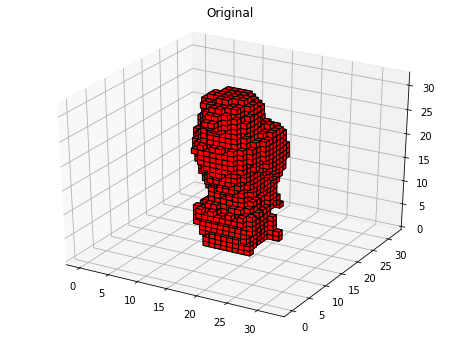

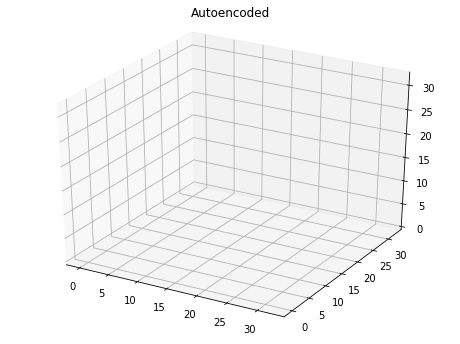

Epoch: 9, Batch: 0, Elapsed time: 1.20 mins
DEBUG_OP "max clipped_output": 0.9998704195022583
DEBUG_OP "min clipped_output": 0.006045077927410603
DEBUG_OP "mean clipped_output": 0.4862300753593445
	KL Divergence = 726.6016235351562, Reconstruction Loss = 574.33056640625
Epoch: 9, Batch: 1, Elapsed time: 1.22 mins
DEBUG_OP "max clipped_output": 0.9999878406524658
DEBUG_OP "min clipped_output": 0.007971201092004776
DEBUG_OP "mean clipped_output": 0.4853866696357727
	KL Divergence = 557.4488525390625, Reconstruction Loss = 598.5806884765625
Epoch: 9, Batch: 2, Elapsed time: 1.23 mins
DEBUG_OP "max clipped_output": 0.9999089241027832
DEBUG_OP "min clipped_output": 0.00576788978651166
DEBUG_OP "mean clipped_output": 0.48242396116256714
	KL Divergence = 603.6103515625, Reconstruction Loss = 567.1832275390625
Epoch: 9, Batch: 3, Elapsed time: 1.24 mins
DEBUG_OP "max clipped_output": 0.9999982118606567
DEBUG_OP "min clipped_output": 0.003430020995438099
DEBUG_OP "mean clipped_output": 0.473291

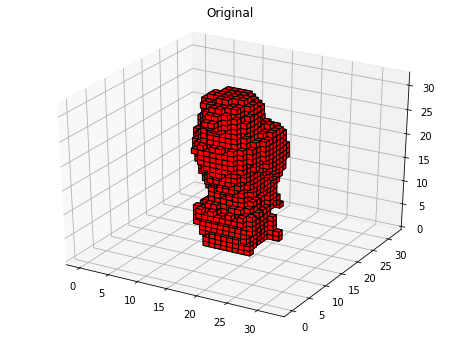

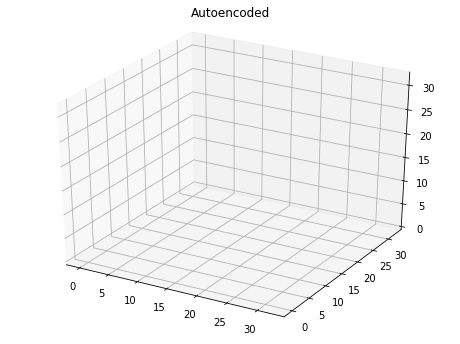

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-9.ckpt
Epoch: 10, Batch: 0, Elapsed time: 1.34 mins
DEBUG_OP "max clipped_output": 0.9999222755432129
DEBUG_OP "min clipped_output": 0.0030462604481726885
DEBUG_OP "mean clipped_output": 0.47223541140556335
	KL Divergence = 702.689697265625, Reconstruction Loss = 513.6671142578125
Epoch: 10, Batch: 1, Elapsed time: 1.36 mins
DEBUG_OP "max clipped_output": 0.999854564666748
DEBUG_OP "min clipped_output": 0.005660573951900005
DEBUG_OP "mean clipped_output": 0.4701852798461914
	KL Divergence = 539.160888671875, Reconstruction Loss = 558.5534057617188
Epoch: 10, Batch: 2, Elapsed time: 1.37 mins
DEBUG_OP "max clipped_output": 0.9999216794967651
DEBUG_OP "min clipped_output": 0.002046524314209819
DEBUG_OP "mean clipped_output": 0.4627910256385803
	KL Divergence = 554.516845703125, Reconstruction Loss = 555.3037719726562
Epoch: 10, Batch: 3, Elapsed time: 1.38 mins
DEBUG_OP "max clipped_output": 0.9999315738

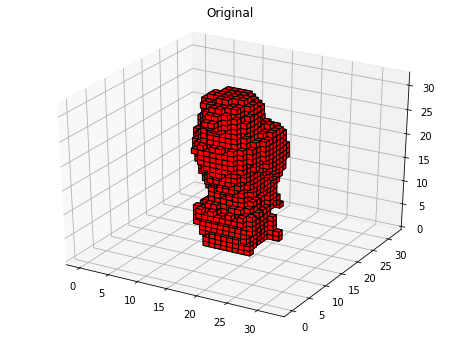

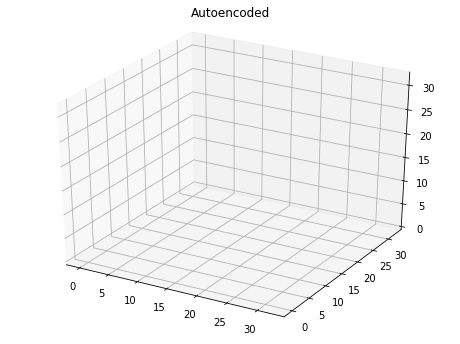

Epoch: 11, Batch: 0, Elapsed time: 1.48 mins
DEBUG_OP "max clipped_output": 0.9997856020927429
DEBUG_OP "min clipped_output": 0.002159623894840479
DEBUG_OP "mean clipped_output": 0.44866544008255005
	KL Divergence = 607.466064453125, Reconstruction Loss = 497.5570068359375
Epoch: 11, Batch: 1, Elapsed time: 1.50 mins
DEBUG_OP "max clipped_output": 0.9998955726623535
DEBUG_OP "min clipped_output": 0.0027871839702129364
DEBUG_OP "mean clipped_output": 0.43810680508613586
	KL Divergence = 659.548583984375, Reconstruction Loss = 536.2615966796875
Epoch: 11, Batch: 2, Elapsed time: 1.51 mins
DEBUG_OP "max clipped_output": 0.9997811913490295
DEBUG_OP "min clipped_output": 0.0024113524705171585
DEBUG_OP "mean clipped_output": 0.43926936388015747
	KL Divergence = 792.2066040039062, Reconstruction Loss = 499.5210266113281
Epoch: 11, Batch: 3, Elapsed time: 1.52 mins
DEBUG_OP "max clipped_output": 0.9999624490737915
DEBUG_OP "min clipped_output": 0.002506903139874339
DEBUG_OP "mean clipped_outpu

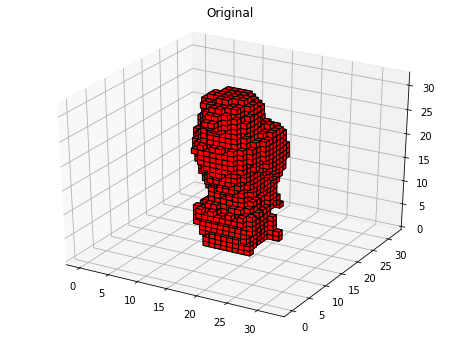

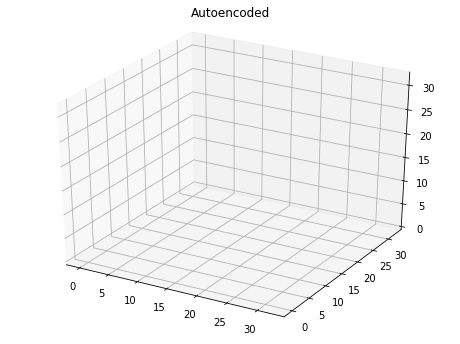

Epoch: 12, Batch: 0, Elapsed time: 1.62 mins
DEBUG_OP "max clipped_output": 0.9998600482940674
DEBUG_OP "min clipped_output": 0.0012942447792738676
DEBUG_OP "mean clipped_output": 0.4335797131061554
	KL Divergence = 843.7255859375, Reconstruction Loss = 475.93988037109375
Epoch: 12, Batch: 1, Elapsed time: 1.63 mins
DEBUG_OP "max clipped_output": 0.9998185038566589
DEBUG_OP "min clipped_output": 0.0020393021404743195
DEBUG_OP "mean clipped_output": 0.431331604719162
	KL Divergence = 714.5980224609375, Reconstruction Loss = 511.7035827636719
Epoch: 12, Batch: 2, Elapsed time: 1.64 mins
DEBUG_OP "max clipped_output": 0.9998220801353455
DEBUG_OP "min clipped_output": 0.0019281868590041995
DEBUG_OP "mean clipped_output": 0.42506036162376404
	KL Divergence = 701.1959838867188, Reconstruction Loss = 494.04644775390625
Epoch: 12, Batch: 3, Elapsed time: 1.66 mins
DEBUG_OP "max clipped_output": 0.9999727010726929
DEBUG_OP "min clipped_output": 0.0016341491136699915
DEBUG_OP "mean clipped_outpu

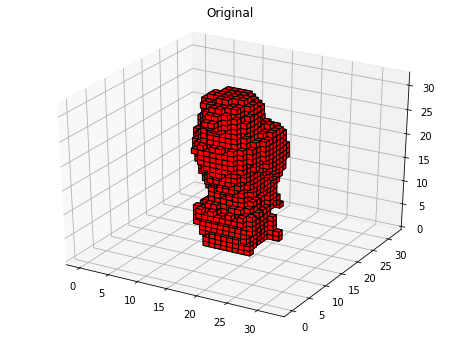

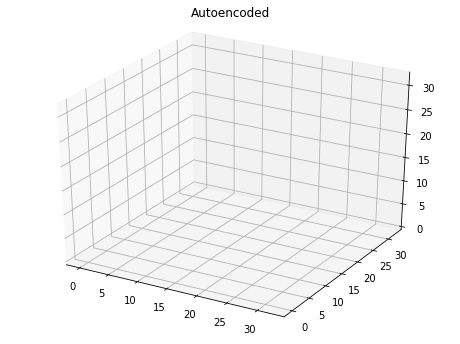

Epoch: 13, Batch: 0, Elapsed time: 1.75 mins
DEBUG_OP "max clipped_output": 0.9999169111251831
DEBUG_OP "min clipped_output": 0.0007953478489071131
DEBUG_OP "mean clipped_output": 0.4207801818847656
	KL Divergence = 756.3792724609375, Reconstruction Loss = 443.1202392578125
Epoch: 13, Batch: 1, Elapsed time: 1.76 mins
DEBUG_OP "max clipped_output": 0.9998983144760132
DEBUG_OP "min clipped_output": 0.0009001613943837583
DEBUG_OP "mean clipped_output": 0.41310060024261475
	KL Divergence = 681.097900390625, Reconstruction Loss = 490.69647216796875
Epoch: 13, Batch: 2, Elapsed time: 1.78 mins
DEBUG_OP "max clipped_output": 0.9998661279678345
DEBUG_OP "min clipped_output": 0.0015242978697642684
DEBUG_OP "mean clipped_output": 0.4084407687187195
	KL Divergence = 722.1898803710938, Reconstruction Loss = 461.6316223144531
Epoch: 13, Batch: 3, Elapsed time: 1.79 mins
DEBUG_OP "max clipped_output": 0.9999690055847168
DEBUG_OP "min clipped_output": 0.000881587213370949
DEBUG_OP "mean clipped_outp

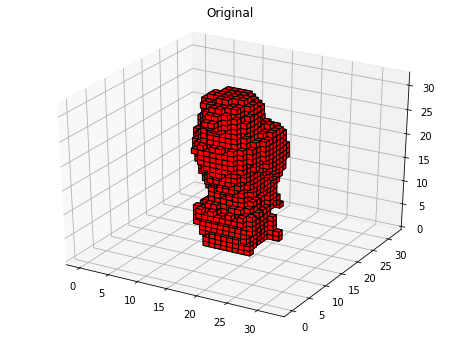

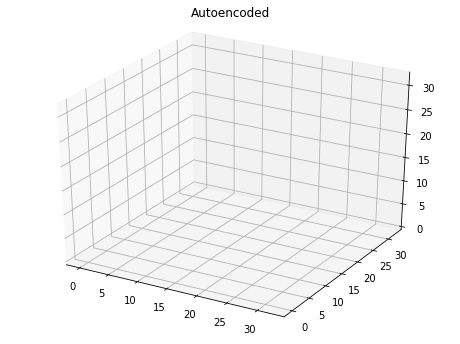

Epoch: 14, Batch: 0, Elapsed time: 1.89 mins
DEBUG_OP "max clipped_output": 0.999713122844696
DEBUG_OP "min clipped_output": 0.00041169399628415704
DEBUG_OP "mean clipped_output": 0.40739819407463074
	KL Divergence = 786.0011596679688, Reconstruction Loss = 446.1324462890625
Epoch: 14, Batch: 1, Elapsed time: 1.90 mins
DEBUG_OP "max clipped_output": 0.9998840093612671
DEBUG_OP "min clipped_output": 0.000874849793035537
DEBUG_OP "mean clipped_output": 0.4042161703109741
	KL Divergence = 717.684814453125, Reconstruction Loss = 486.66156005859375
Epoch: 14, Batch: 2, Elapsed time: 1.91 mins
DEBUG_OP "max clipped_output": 0.9997419714927673
DEBUG_OP "min clipped_output": 0.0008046726579777896
DEBUG_OP "mean clipped_output": 0.4087899327278137
	KL Divergence = 637.0955810546875, Reconstruction Loss = 486.8562316894531
Epoch: 14, Batch: 3, Elapsed time: 1.93 mins
DEBUG_OP "max clipped_output": 0.9999340772628784
DEBUG_OP "min clipped_output": 0.0004152140172664076
DEBUG_OP "mean clipped_outp

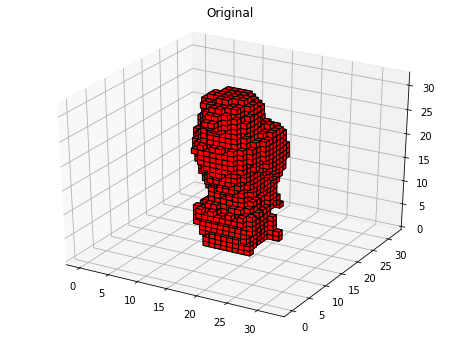

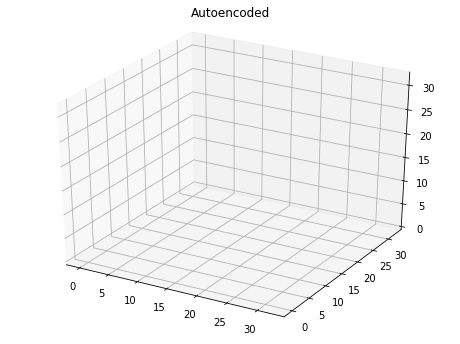

Epoch: 15, Batch: 0, Elapsed time: 2.03 mins
DEBUG_OP "max clipped_output": 0.9998133778572083
DEBUG_OP "min clipped_output": 0.0006783530116081238
DEBUG_OP "mean clipped_output": 0.402596116065979
	KL Divergence = 783.5206298828125, Reconstruction Loss = 453.7401123046875
Epoch: 15, Batch: 1, Elapsed time: 2.04 mins
DEBUG_OP "max clipped_output": 0.9997280240058899
DEBUG_OP "min clipped_output": 0.000821503228507936
DEBUG_OP "mean clipped_output": 0.4007915258407593
	KL Divergence = 690.38037109375, Reconstruction Loss = 467.1764831542969
Epoch: 15, Batch: 2, Elapsed time: 2.05 mins
DEBUG_OP "max clipped_output": 0.9998281002044678
DEBUG_OP "min clipped_output": 0.000614250311627984
DEBUG_OP "mean clipped_output": 0.4003734588623047
	KL Divergence = 594.481201171875, Reconstruction Loss = 497.1871337890625
Epoch: 15, Batch: 3, Elapsed time: 2.07 mins
DEBUG_OP "max clipped_output": 0.9997431635856628
DEBUG_OP "min clipped_output": 0.0004308715579099953
DEBUG_OP "mean clipped_output": 0

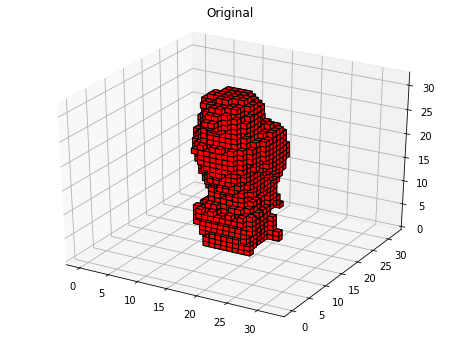

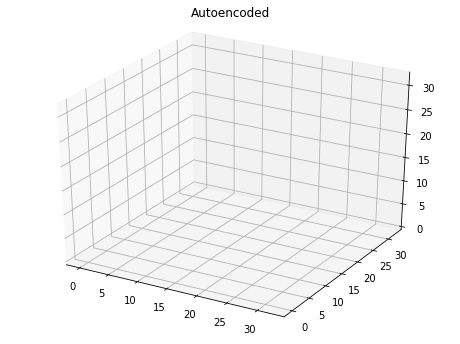

Epoch: 16, Batch: 0, Elapsed time: 2.16 mins
DEBUG_OP "max clipped_output": 0.9998216032981873
DEBUG_OP "min clipped_output": 0.00028547056717798114
DEBUG_OP "mean clipped_output": 0.4016875922679901
	KL Divergence = 735.8203735351562, Reconstruction Loss = 441.06011962890625
Epoch: 16, Batch: 1, Elapsed time: 2.17 mins
DEBUG_OP "max clipped_output": 0.99983811378479
DEBUG_OP "min clipped_output": 0.0004523697425611317
DEBUG_OP "mean clipped_output": 0.39347875118255615
	KL Divergence = 793.2847900390625, Reconstruction Loss = 457.61761474609375
Epoch: 16, Batch: 2, Elapsed time: 2.19 mins
DEBUG_OP "max clipped_output": 0.9998457431793213
DEBUG_OP "min clipped_output": 0.00041680748108774424
DEBUG_OP "mean clipped_output": 0.393903523683548
	KL Divergence = 732.648193359375, Reconstruction Loss = 437.0920104980469
Epoch: 16, Batch: 3, Elapsed time: 2.20 mins
DEBUG_OP "max clipped_output": 0.9997606873512268
DEBUG_OP "min clipped_output": 0.000428925413871184
DEBUG_OP "mean clipped_outp

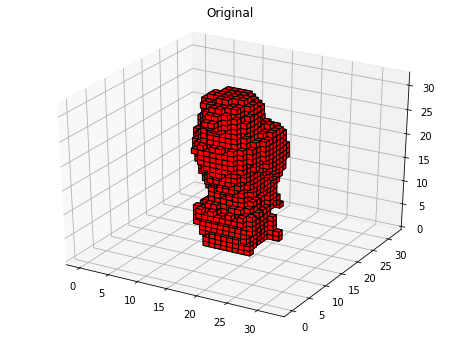

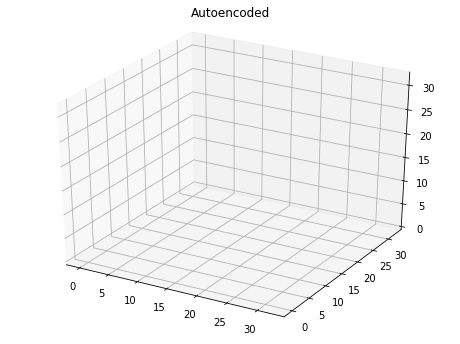

Epoch: 17, Batch: 0, Elapsed time: 2.29 mins
DEBUG_OP "max clipped_output": 0.9996232986450195
DEBUG_OP "min clipped_output": 0.00045727886026725173
DEBUG_OP "mean clipped_output": 0.39832618832588196
	KL Divergence = 731.657470703125, Reconstruction Loss = 419.5185241699219
Epoch: 17, Batch: 1, Elapsed time: 2.30 mins
DEBUG_OP "max clipped_output": 0.9997686743736267
DEBUG_OP "min clipped_output": 0.00045992102241143584
DEBUG_OP "mean clipped_output": 0.388709157705307
	KL Divergence = 632.1922607421875, Reconstruction Loss = 467.9917297363281
Epoch: 17, Batch: 2, Elapsed time: 2.32 mins
DEBUG_OP "max clipped_output": 0.9997302889823914
DEBUG_OP "min clipped_output": 0.000573430210351944
DEBUG_OP "mean clipped_output": 0.3842083811759949
	KL Divergence = 778.4617309570312, Reconstruction Loss = 447.3770751953125
Epoch: 17, Batch: 3, Elapsed time: 2.33 mins
DEBUG_OP "max clipped_output": 0.9998445510864258
DEBUG_OP "min clipped_output": 0.0003568009997252375
DEBUG_OP "mean clipped_outp

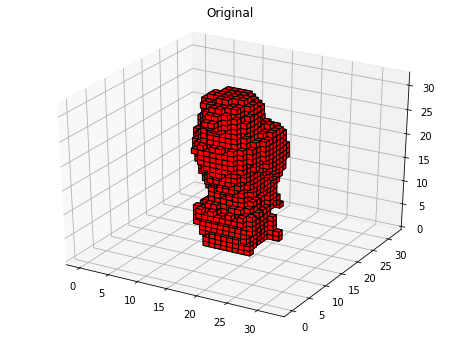

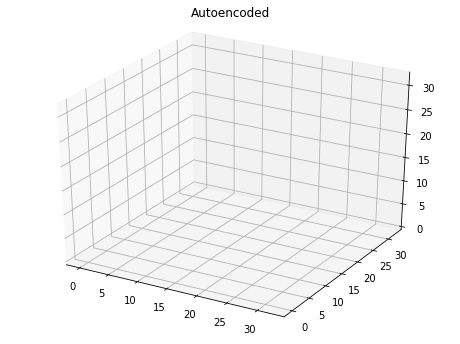

Epoch: 18, Batch: 0, Elapsed time: 2.43 mins
DEBUG_OP "max clipped_output": 0.9995530247688293
DEBUG_OP "min clipped_output": 0.0004523246898315847
DEBUG_OP "mean clipped_output": 0.3970648944377899
	KL Divergence = 842.56494140625, Reconstruction Loss = 407.38018798828125
Epoch: 18, Batch: 1, Elapsed time: 2.44 mins
DEBUG_OP "max clipped_output": 0.9996697902679443
DEBUG_OP "min clipped_output": 0.00041182199493050575
DEBUG_OP "mean clipped_output": 0.38931453227996826
	KL Divergence = 740.6373291015625, Reconstruction Loss = 459.258056640625
Epoch: 18, Batch: 2, Elapsed time: 2.46 mins
DEBUG_OP "max clipped_output": 0.9997887015342712
DEBUG_OP "min clipped_output": 0.0006041900487616658
DEBUG_OP "mean clipped_output": 0.3935948610305786
	KL Divergence = 758.1918334960938, Reconstruction Loss = 422.2728271484375
Epoch: 18, Batch: 3, Elapsed time: 2.47 mins
DEBUG_OP "max clipped_output": 0.9999092817306519
DEBUG_OP "min clipped_output": 0.00017269336967729032
DEBUG_OP "mean clipped_out

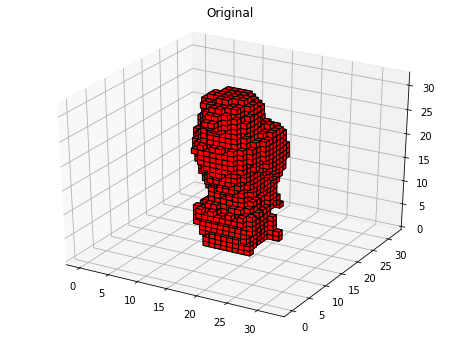

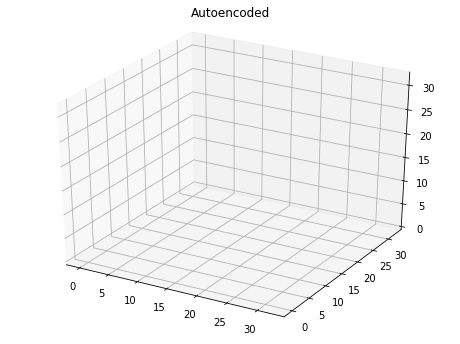

Epoch: 19, Batch: 0, Elapsed time: 2.56 mins
DEBUG_OP "max clipped_output": 0.9998440742492676
DEBUG_OP "min clipped_output": 0.00026994303334504366
DEBUG_OP "mean clipped_output": 0.3851615786552429
	KL Divergence = 754.5374145507812, Reconstruction Loss = 421.4720458984375
Epoch: 19, Batch: 1, Elapsed time: 2.58 mins
DEBUG_OP "max clipped_output": 0.9998462200164795
DEBUG_OP "min clipped_output": 0.0004056391480844468
DEBUG_OP "mean clipped_output": 0.37442752718925476
	KL Divergence = 857.2525024414062, Reconstruction Loss = 425.64306640625
Epoch: 19, Batch: 2, Elapsed time: 2.59 mins
DEBUG_OP "max clipped_output": 0.9997363686561584
DEBUG_OP "min clipped_output": 0.00044971524039283395
DEBUG_OP "mean clipped_output": 0.3791579604148865
	KL Divergence = 798.32958984375, Reconstruction Loss = 427.26861572265625
Epoch: 19, Batch: 3, Elapsed time: 2.60 mins
DEBUG_OP "max clipped_output": 0.9998853206634521
DEBUG_OP "min clipped_output": 0.0001677342806942761
DEBUG_OP "mean clipped_outp

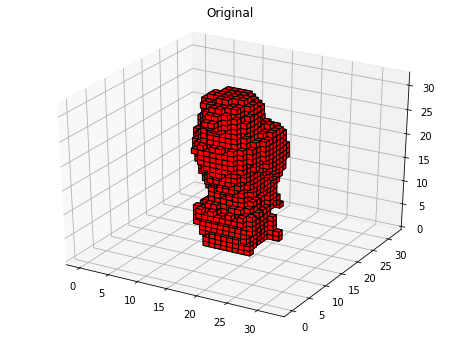

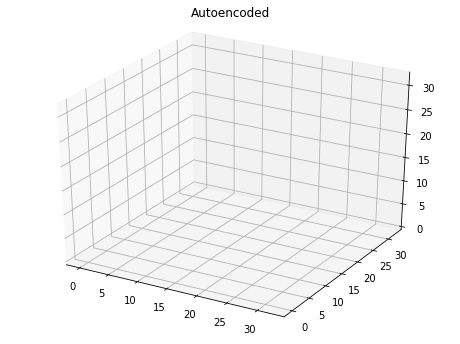

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-19.ckpt
Epoch: 20, Batch: 0, Elapsed time: 2.70 mins
DEBUG_OP "max clipped_output": 0.9999353885650635
DEBUG_OP "min clipped_output": 0.00011218039435334504
DEBUG_OP "mean clipped_output": 0.3758993446826935
	KL Divergence = 810.2693481445312, Reconstruction Loss = 387.5302429199219
Epoch: 20, Batch: 1, Elapsed time: 2.72 mins
DEBUG_OP "max clipped_output": 0.9998084902763367
DEBUG_OP "min clipped_output": 0.0001455136080039665
DEBUG_OP "mean clipped_output": 0.3693419396877289
	KL Divergence = 729.938720703125, Reconstruction Loss = 425.43792724609375
Epoch: 20, Batch: 2, Elapsed time: 2.73 mins
DEBUG_OP "max clipped_output": 0.999795138835907
DEBUG_OP "min clipped_output": 0.00022734944650437683
DEBUG_OP "mean clipped_output": 0.3665439188480377
	KL Divergence = 679.702392578125, Reconstruction Loss = 441.46588134765625
Epoch: 20, Batch: 3, Elapsed time: 2.74 mins
DEBUG_OP "max clipped_output": 0.999

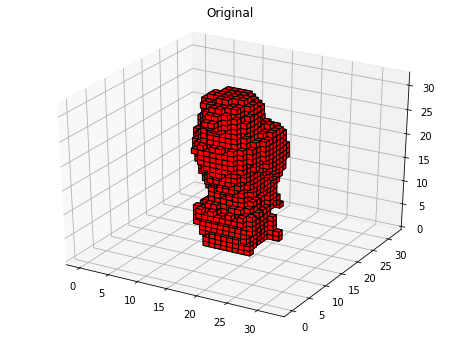

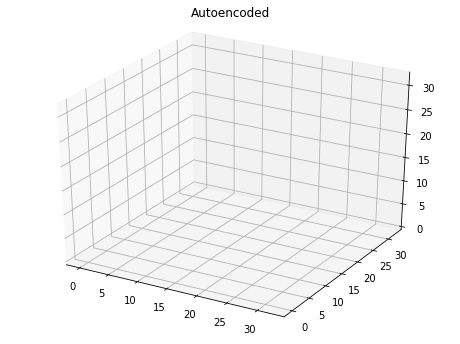

Epoch: 21, Batch: 0, Elapsed time: 2.84 mins
DEBUG_OP "max clipped_output": 0.9996970891952515
DEBUG_OP "min clipped_output": 0.00014018946967553347
DEBUG_OP "mean clipped_output": 0.38178175687789917
	KL Divergence = 989.8104248046875, Reconstruction Loss = 398.3835144042969
Epoch: 21, Batch: 1, Elapsed time: 2.85 mins
DEBUG_OP "max clipped_output": 0.9998261332511902
DEBUG_OP "min clipped_output": 0.00021085610205773264
DEBUG_OP "mean clipped_output": 0.36907729506492615
	KL Divergence = 901.251953125, Reconstruction Loss = 444.3728942871094
Epoch: 21, Batch: 2, Elapsed time: 2.87 mins
DEBUG_OP "max clipped_output": 0.9997147917747498
DEBUG_OP "min clipped_output": 0.0003798161051236093
DEBUG_OP "mean clipped_output": 0.3755169212818146
	KL Divergence = 944.9564208984375, Reconstruction Loss = 397.3679504394531
Epoch: 21, Batch: 3, Elapsed time: 2.88 mins
DEBUG_OP "max clipped_output": 0.9998316764831543
DEBUG_OP "min clipped_output": 0.0001805629872251302
DEBUG_OP "mean clipped_outp

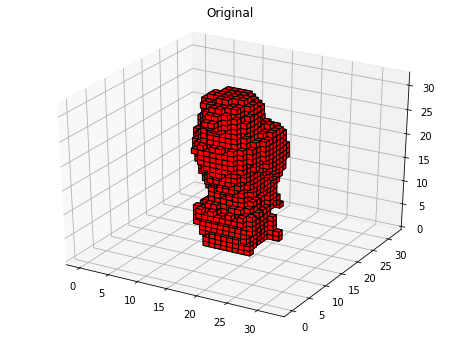

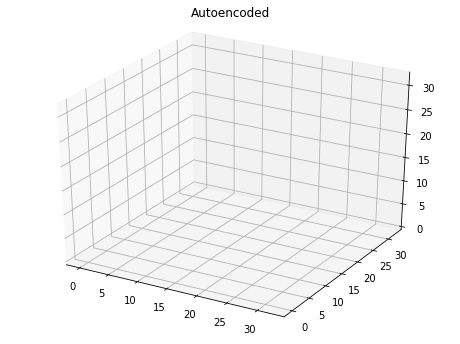

Epoch: 22, Batch: 0, Elapsed time: 2.98 mins
DEBUG_OP "max clipped_output": 0.999840497970581
DEBUG_OP "min clipped_output": 0.00012858268746640533
DEBUG_OP "mean clipped_output": 0.3717191815376282
	KL Divergence = 919.630859375, Reconstruction Loss = 384.926025390625
Epoch: 22, Batch: 1, Elapsed time: 2.99 mins
DEBUG_OP "max clipped_output": 0.9998165965080261
DEBUG_OP "min clipped_output": 0.0002029503957601264
DEBUG_OP "mean clipped_output": 0.3690115213394165
	KL Divergence = 810.2152099609375, Reconstruction Loss = 440.4601745605469
Epoch: 22, Batch: 2, Elapsed time: 3.00 mins
DEBUG_OP "max clipped_output": 0.9997376799583435
DEBUG_OP "min clipped_output": 0.0002581385488156229
DEBUG_OP "mean clipped_output": 0.37375640869140625
	KL Divergence = 819.7695922851562, Reconstruction Loss = 400.63848876953125
Epoch: 22, Batch: 3, Elapsed time: 3.02 mins
DEBUG_OP "max clipped_output": 0.9998812675476074
DEBUG_OP "min clipped_output": 0.00015244762471411377
DEBUG_OP "mean clipped_output

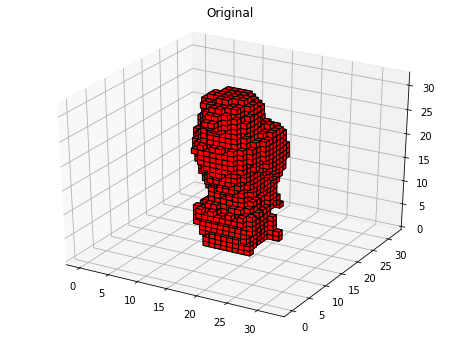

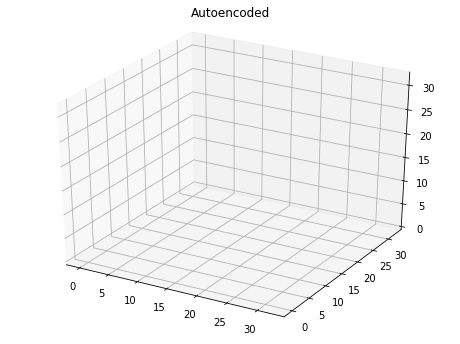

Epoch: 23, Batch: 0, Elapsed time: 3.11 mins
DEBUG_OP "max clipped_output": 0.9998341798782349
DEBUG_OP "min clipped_output": 0.00014049017045181245
DEBUG_OP "mean clipped_output": 0.36830779910087585
	KL Divergence = 817.3966064453125, Reconstruction Loss = 381.889892578125
Epoch: 23, Batch: 1, Elapsed time: 3.12 mins
DEBUG_OP "max clipped_output": 0.999847412109375
DEBUG_OP "min clipped_output": 0.00022469769464805722
DEBUG_OP "mean clipped_output": 0.36182859539985657
	KL Divergence = 813.939453125, Reconstruction Loss = 412.4012756347656
Epoch: 23, Batch: 2, Elapsed time: 3.14 mins
DEBUG_OP "max clipped_output": 0.9997462630271912
DEBUG_OP "min clipped_output": 0.00017096746887546033
DEBUG_OP "mean clipped_output": 0.3648242950439453
	KL Divergence = 762.0478515625, Reconstruction Loss = 393.85614013671875
Epoch: 23, Batch: 3, Elapsed time: 3.15 mins
DEBUG_OP "max clipped_output": 0.9999492168426514
DEBUG_OP "min clipped_output": 0.00011709184036590159
DEBUG_OP "mean clipped_output

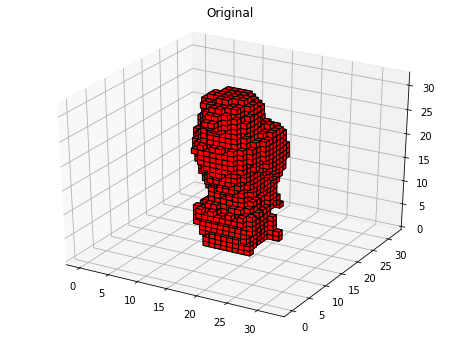

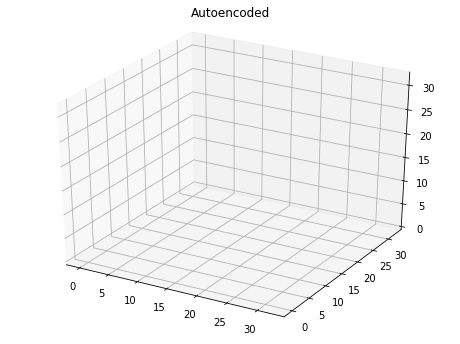

Epoch: 24, Batch: 0, Elapsed time: 3.25 mins
DEBUG_OP "max clipped_output": 0.9998764991760254
DEBUG_OP "min clipped_output": 0.00010594222840154544
DEBUG_OP "mean clipped_output": 0.3661772906780243
	KL Divergence = 980.3666381835938, Reconstruction Loss = 386.8471984863281
Epoch: 24, Batch: 1, Elapsed time: 3.26 mins
DEBUG_OP "max clipped_output": 0.9997223019599915
DEBUG_OP "min clipped_output": 0.0002932852949015796
DEBUG_OP "mean clipped_output": 0.35808610916137695
	KL Divergence = 908.2974853515625, Reconstruction Loss = 410.97052001953125
Epoch: 24, Batch: 2, Elapsed time: 3.27 mins
DEBUG_OP "max clipped_output": 0.9998231530189514
DEBUG_OP "min clipped_output": 0.0002619507140479982
DEBUG_OP "mean clipped_output": 0.359220415353775
	KL Divergence = 827.5374755859375, Reconstruction Loss = 405.15118408203125
Epoch: 24, Batch: 3, Elapsed time: 3.29 mins
DEBUG_OP "max clipped_output": 0.9999358654022217
DEBUG_OP "min clipped_output": 0.00017630128422752023
DEBUG_OP "mean clipped_

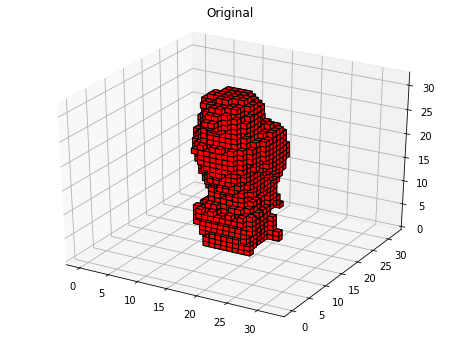

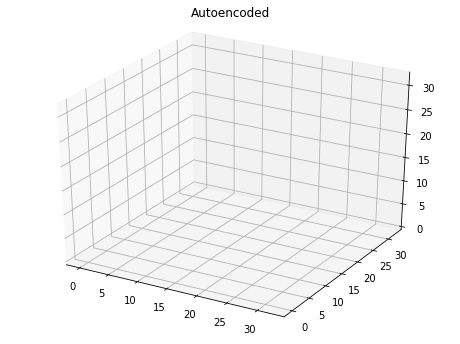

Epoch: 25, Batch: 0, Elapsed time: 3.38 mins
DEBUG_OP "max clipped_output": 0.9998966455459595
DEBUG_OP "min clipped_output": 0.00013877672608941793
DEBUG_OP "mean clipped_output": 0.3627180755138397
	KL Divergence = 759.8594360351562, Reconstruction Loss = 366.81982421875
Epoch: 25, Batch: 1, Elapsed time: 3.40 mins
DEBUG_OP "max clipped_output": 0.999862551689148
DEBUG_OP "min clipped_output": 0.00019143531972076744
DEBUG_OP "mean clipped_output": 0.3551442623138428
	KL Divergence = 709.6773681640625, Reconstruction Loss = 416.68865966796875
Epoch: 25, Batch: 2, Elapsed time: 3.41 mins
DEBUG_OP "max clipped_output": 0.9999604225158691
DEBUG_OP "min clipped_output": 0.0001564010017318651
DEBUG_OP "mean clipped_output": 0.3587401509284973
	KL Divergence = 814.58056640625, Reconstruction Loss = 392.5886535644531
Epoch: 25, Batch: 3, Elapsed time: 3.43 mins
DEBUG_OP "max clipped_output": 0.9999204874038696
DEBUG_OP "min clipped_output": 0.00018556301074568182
DEBUG_OP "mean clipped_outpu

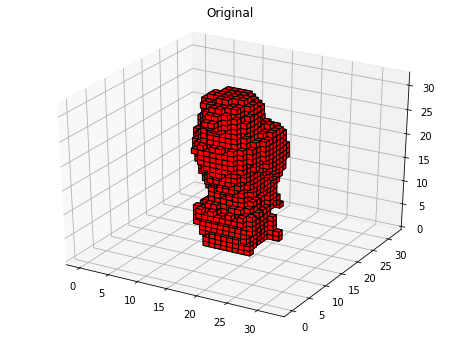

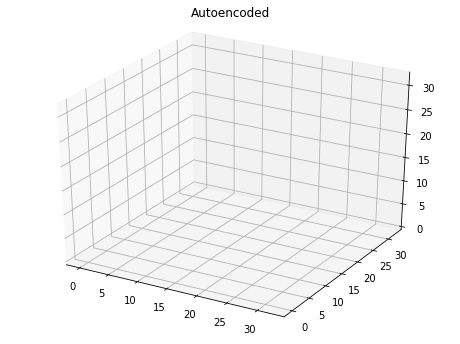

Epoch: 26, Batch: 0, Elapsed time: 3.52 mins
DEBUG_OP "max clipped_output": 0.9999053478240967
DEBUG_OP "min clipped_output": 8.794837776804343e-05
DEBUG_OP "mean clipped_output": 0.35273486375808716
	KL Divergence = 736.336669921875, Reconstruction Loss = 388.2284240722656
Epoch: 26, Batch: 1, Elapsed time: 3.53 mins
DEBUG_OP "max clipped_output": 0.9999384880065918
DEBUG_OP "min clipped_output": 0.00016863393830135465
DEBUG_OP "mean clipped_output": 0.3480597734451294
	KL Divergence = 778.9639282226562, Reconstruction Loss = 404.16693115234375
Epoch: 26, Batch: 2, Elapsed time: 3.55 mins
DEBUG_OP "max clipped_output": 0.9999135732650757
DEBUG_OP "min clipped_output": 0.0001878696057246998
DEBUG_OP "mean clipped_output": 0.3555828928947449
	KL Divergence = 877.6365966796875, Reconstruction Loss = 378.9014892578125
Epoch: 26, Batch: 3, Elapsed time: 3.56 mins
DEBUG_OP "max clipped_output": 0.9998666048049927
DEBUG_OP "min clipped_output": 0.0001331995881628245
DEBUG_OP "mean clipped_ou

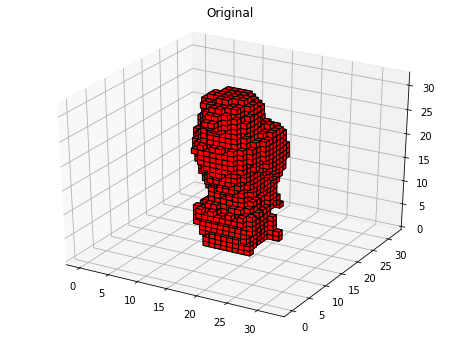

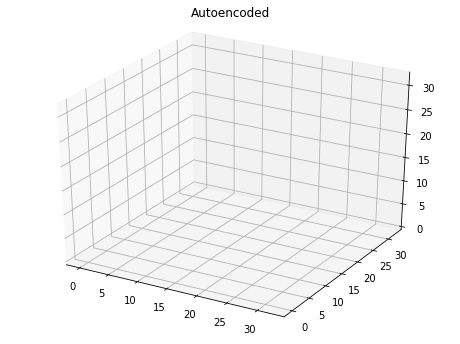

Epoch: 27, Batch: 0, Elapsed time: 3.65 mins
DEBUG_OP "max clipped_output": 0.9998812675476074
DEBUG_OP "min clipped_output": 9.92851855698973e-05
DEBUG_OP "mean clipped_output": 0.35256004333496094
	KL Divergence = 919.4147338867188, Reconstruction Loss = 367.07415771484375
Epoch: 27, Batch: 1, Elapsed time: 3.66 mins
DEBUG_OP "max clipped_output": 0.9999268054962158
DEBUG_OP "min clipped_output": 0.00010854349966393784
DEBUG_OP "mean clipped_output": 0.34689024090766907
	KL Divergence = 927.56591796875, Reconstruction Loss = 383.70367431640625
Epoch: 27, Batch: 2, Elapsed time: 3.68 mins
DEBUG_OP "max clipped_output": 0.9998651742935181
DEBUG_OP "min clipped_output": 0.00014124478911980987
DEBUG_OP "mean clipped_output": 0.3525891900062561
	KL Divergence = 826.0865478515625, Reconstruction Loss = 377.30902099609375
Epoch: 27, Batch: 3, Elapsed time: 3.69 mins
DEBUG_OP "max clipped_output": 0.9999117851257324
DEBUG_OP "min clipped_output": 0.00011489610915305093
DEBUG_OP "mean clipped

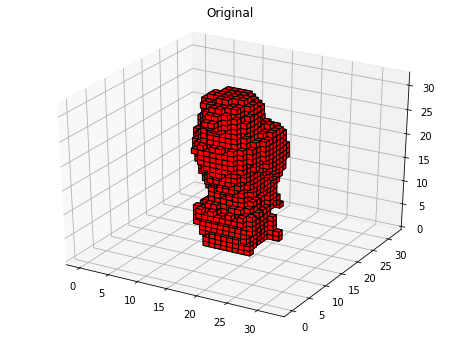

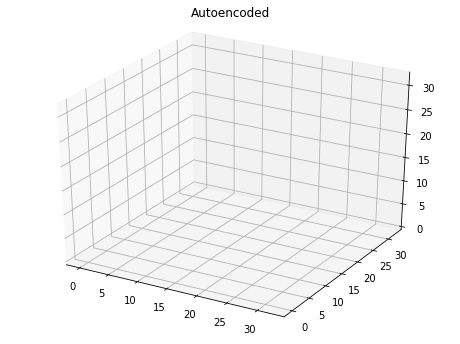

Epoch: 28, Batch: 0, Elapsed time: 3.79 mins
DEBUG_OP "max clipped_output": 0.9997499585151672
DEBUG_OP "min clipped_output": 0.00019572021847125143
DEBUG_OP "mean clipped_output": 0.3492359519004822
	KL Divergence = 1073.2474365234375, Reconstruction Loss = 368.5883483886719
Epoch: 28, Batch: 1, Elapsed time: 3.80 mins
DEBUG_OP "max clipped_output": 0.9999350309371948
DEBUG_OP "min clipped_output": 0.00016470273840241134
DEBUG_OP "mean clipped_output": 0.3409949243068695
	KL Divergence = 906.3408813476562, Reconstruction Loss = 390.7756042480469
Epoch: 28, Batch: 2, Elapsed time: 3.82 mins
DEBUG_OP "max clipped_output": 0.999933123588562
DEBUG_OP "min clipped_output": 0.00014711706899106503
DEBUG_OP "mean clipped_output": 0.35165104269981384
	KL Divergence = 869.5880126953125, Reconstruction Loss = 378.09747314453125
Epoch: 28, Batch: 3, Elapsed time: 3.83 mins
DEBUG_OP "max clipped_output": 0.9999525547027588
DEBUG_OP "min clipped_output": 0.00013130770821589977
DEBUG_OP "mean clippe

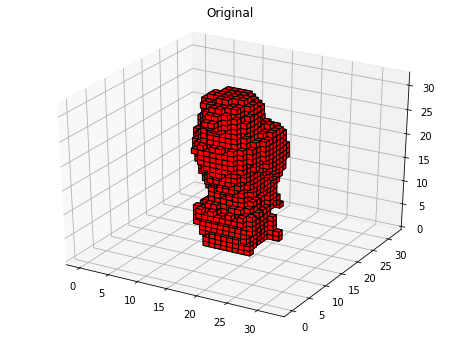

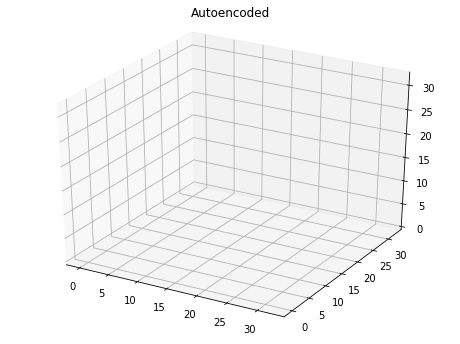

Epoch: 29, Batch: 0, Elapsed time: 3.92 mins
DEBUG_OP "max clipped_output": 0.9998492002487183
DEBUG_OP "min clipped_output": 0.00011624943726928905
DEBUG_OP "mean clipped_output": 0.35041648149490356
	KL Divergence = 708.4013061523438, Reconstruction Loss = 372.87615966796875
Epoch: 29, Batch: 1, Elapsed time: 3.94 mins
DEBUG_OP "max clipped_output": 0.9998942613601685
DEBUG_OP "min clipped_output": 0.00016330003563780338
DEBUG_OP "mean clipped_output": 0.3450455367565155
	KL Divergence = 751.792236328125, Reconstruction Loss = 387.1045227050781
Epoch: 29, Batch: 2, Elapsed time: 3.95 mins
DEBUG_OP "max clipped_output": 0.9997871518135071
DEBUG_OP "min clipped_output": 0.00014966576418373734
DEBUG_OP "mean clipped_output": 0.35189300775527954
	KL Divergence = 809.3505249023438, Reconstruction Loss = 375.82464599609375
Epoch: 29, Batch: 3, Elapsed time: 3.96 mins
DEBUG_OP "max clipped_output": 0.9998934268951416
DEBUG_OP "min clipped_output": 6.696664058836177e-05
DEBUG_OP "mean clippe

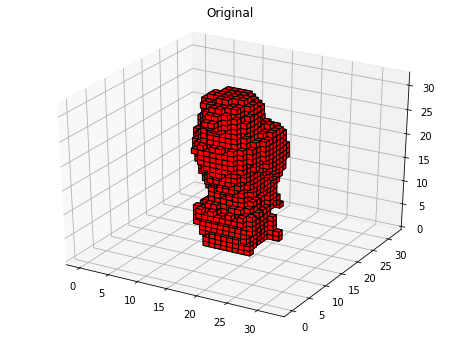

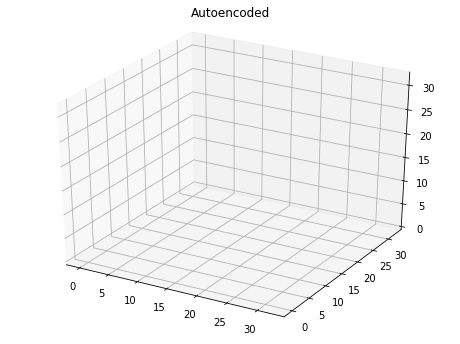

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-29.ckpt
Epoch: 30, Batch: 0, Elapsed time: 4.06 mins
DEBUG_OP "max clipped_output": 0.999934196472168
DEBUG_OP "min clipped_output": 5.1270606491016224e-05
DEBUG_OP "mean clipped_output": 0.34304606914520264
	KL Divergence = 740.6959838867188, Reconstruction Loss = 360.93206787109375
Epoch: 30, Batch: 1, Elapsed time: 4.08 mins
DEBUG_OP "max clipped_output": 0.9999023675918579
DEBUG_OP "min clipped_output": 5.5931148381205276e-05
DEBUG_OP "mean clipped_output": 0.3381269574165344
	KL Divergence = 814.51318359375, Reconstruction Loss = 377.7450256347656
Epoch: 30, Batch: 2, Elapsed time: 4.09 mins
DEBUG_OP "max clipped_output": 0.9998288154602051
DEBUG_OP "min clipped_output": 9.777738887351006e-05
DEBUG_OP "mean clipped_output": 0.34210389852523804
	KL Divergence = 863.1160888671875, Reconstruction Loss = 371.7048645019531
Epoch: 30, Batch: 3, Elapsed time: 4.10 mins
DEBUG_OP "max clipped_output": 0.99

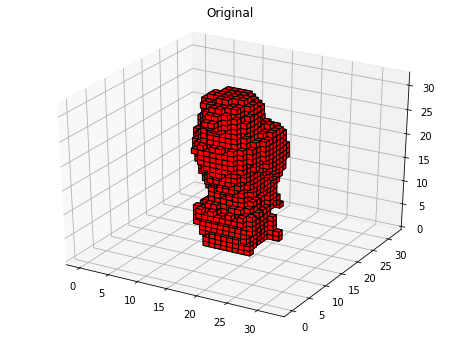

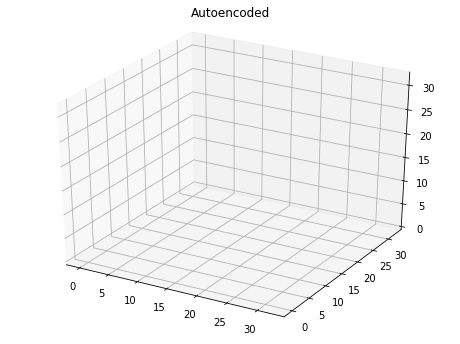

Epoch: 31, Batch: 0, Elapsed time: 4.20 mins
DEBUG_OP "max clipped_output": 0.9998800754547119
DEBUG_OP "min clipped_output": 5.600768417934887e-05
DEBUG_OP "mean clipped_output": 0.3410564363002777
	KL Divergence = 803.7825927734375, Reconstruction Loss = 344.92718505859375
Epoch: 31, Batch: 1, Elapsed time: 4.21 mins
DEBUG_OP "max clipped_output": 0.9999287128448486
DEBUG_OP "min clipped_output": 0.00010947423288598657
DEBUG_OP "mean clipped_output": 0.334743857383728
	KL Divergence = 759.9285888671875, Reconstruction Loss = 378.6139831542969
Epoch: 31, Batch: 2, Elapsed time: 4.22 mins
DEBUG_OP "max clipped_output": 0.9998397827148438
DEBUG_OP "min clipped_output": 9.890390356304124e-05
DEBUG_OP "mean clipped_output": 0.3407564163208008
	KL Divergence = 810.0146484375, Reconstruction Loss = 386.4930114746094
Epoch: 31, Batch: 3, Elapsed time: 4.24 mins
DEBUG_OP "max clipped_output": 0.9999470710754395
DEBUG_OP "min clipped_output": 6.474101246567443e-05
DEBUG_OP "mean clipped_output

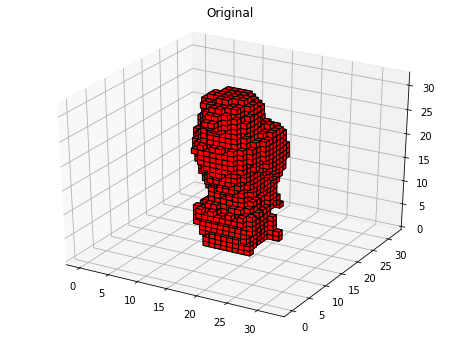

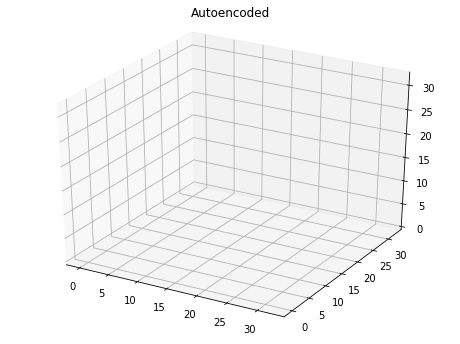

Epoch: 32, Batch: 0, Elapsed time: 4.33 mins
DEBUG_OP "max clipped_output": 0.9998666048049927
DEBUG_OP "min clipped_output": 3.9786096749594435e-05
DEBUG_OP "mean clipped_output": 0.33748501539230347
	KL Divergence = 738.3758544921875, Reconstruction Loss = 345.69317626953125
Epoch: 32, Batch: 1, Elapsed time: 4.35 mins
DEBUG_OP "max clipped_output": 0.9999542236328125
DEBUG_OP "min clipped_output": 6.138344906503335e-05
DEBUG_OP "mean clipped_output": 0.3267667889595032
	KL Divergence = 713.7999877929688, Reconstruction Loss = 384.20263671875
Epoch: 32, Batch: 2, Elapsed time: 4.36 mins
DEBUG_OP "max clipped_output": 0.9998971223831177
DEBUG_OP "min clipped_output": 5.599054566118866e-05
DEBUG_OP "mean clipped_output": 0.3314289450645447
	KL Divergence = 825.68017578125, Reconstruction Loss = 375.094482421875
Epoch: 32, Batch: 3, Elapsed time: 4.38 mins
DEBUG_OP "max clipped_output": 0.999947190284729
DEBUG_OP "min clipped_output": 4.560836896416731e-05
DEBUG_OP "mean clipped_output"

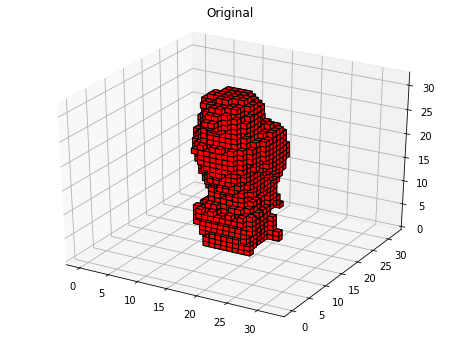

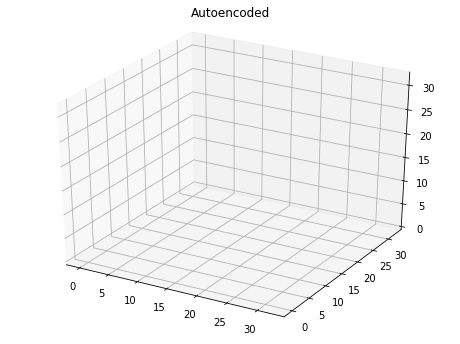

Epoch: 33, Batch: 0, Elapsed time: 4.47 mins
DEBUG_OP "max clipped_output": 0.9998775720596313
DEBUG_OP "min clipped_output": 3.3876563975354657e-05
DEBUG_OP "mean clipped_output": 0.3386325240135193
	KL Divergence = 854.031005859375, Reconstruction Loss = 326.6903381347656
Epoch: 33, Batch: 1, Elapsed time: 4.48 mins
DEBUG_OP "max clipped_output": 0.999897837638855
DEBUG_OP "min clipped_output": 2.6944055207422934e-05
DEBUG_OP "mean clipped_output": 0.32485246658325195
	KL Divergence = 697.337646484375, Reconstruction Loss = 389.47930908203125
Epoch: 33, Batch: 2, Elapsed time: 4.50 mins
DEBUG_OP "max clipped_output": 0.9997774958610535
DEBUG_OP "min clipped_output": 4.746026388602331e-05
DEBUG_OP "mean clipped_output": 0.33881133794784546
	KL Divergence = 858.6136474609375, Reconstruction Loss = 351.1982421875
Epoch: 33, Batch: 3, Elapsed time: 4.51 mins
DEBUG_OP "max clipped_output": 0.9999868869781494
DEBUG_OP "min clipped_output": 2.7689235139405355e-05
DEBUG_OP "mean clipped_outp

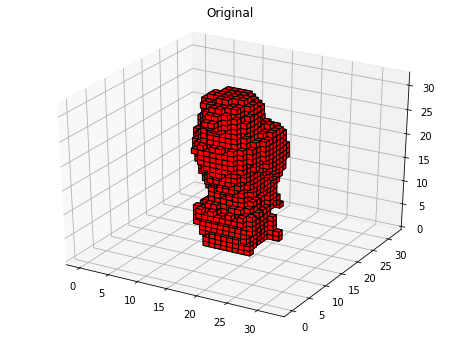

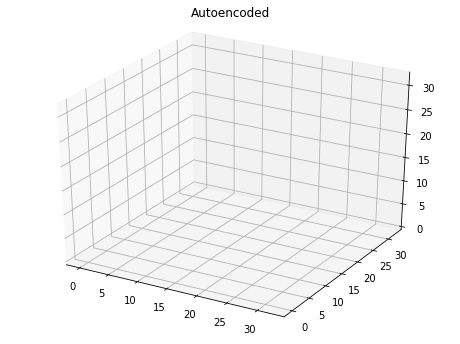

Epoch: 34, Batch: 0, Elapsed time: 4.60 mins
DEBUG_OP "max clipped_output": 0.999923825263977
DEBUG_OP "min clipped_output": 2.9078144507366233e-05
DEBUG_OP "mean clipped_output": 0.3284965455532074
	KL Divergence = 767.5090942382812, Reconstruction Loss = 335.78399658203125
Epoch: 34, Batch: 1, Elapsed time: 4.61 mins
DEBUG_OP "max clipped_output": 0.9999339580535889
DEBUG_OP "min clipped_output": 4.0224251279141754e-05
DEBUG_OP "mean clipped_output": 0.3173213005065918
	KL Divergence = 726.7385864257812, Reconstruction Loss = 378.73529052734375
Epoch: 34, Batch: 2, Elapsed time: 4.63 mins
DEBUG_OP "max clipped_output": 0.9999010562896729
DEBUG_OP "min clipped_output": 7.389562233584002e-05
DEBUG_OP "mean clipped_output": 0.3264371454715729
	KL Divergence = 858.907958984375, Reconstruction Loss = 369.11767578125
Epoch: 34, Batch: 3, Elapsed time: 4.64 mins
DEBUG_OP "max clipped_output": 0.9999408721923828
DEBUG_OP "min clipped_output": 4.0166520193452016e-05
DEBUG_OP "mean clipped_out

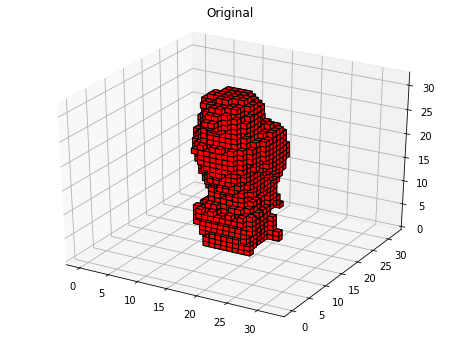

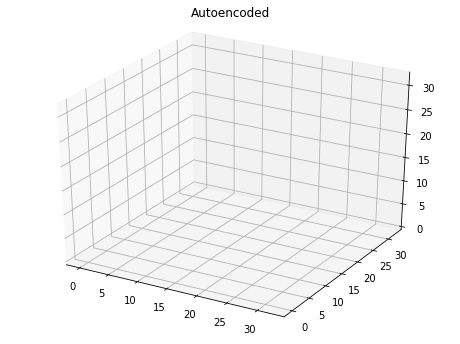

Epoch: 35, Batch: 0, Elapsed time: 4.74 mins
DEBUG_OP "max clipped_output": 0.9999306201934814
DEBUG_OP "min clipped_output": 2.7014397346647456e-05
DEBUG_OP "mean clipped_output": 0.3306117355823517
	KL Divergence = 725.1471557617188, Reconstruction Loss = 345.7760009765625
Epoch: 35, Batch: 1, Elapsed time: 4.75 mins
DEBUG_OP "max clipped_output": 0.9999409914016724
DEBUG_OP "min clipped_output": 3.072076287935488e-05
DEBUG_OP "mean clipped_output": 0.3230912387371063
	KL Divergence = 731.309814453125, Reconstruction Loss = 368.16619873046875
Epoch: 35, Batch: 2, Elapsed time: 4.77 mins
DEBUG_OP "max clipped_output": 0.9998874664306641
DEBUG_OP "min clipped_output": 4.230066770105623e-05
DEBUG_OP "mean clipped_output": 0.33415549993515015
	KL Divergence = 828.6427001953125, Reconstruction Loss = 342.11187744140625
Epoch: 35, Batch: 3, Elapsed time: 4.78 mins
DEBUG_OP "max clipped_output": 0.9998598098754883
DEBUG_OP "min clipped_output": 3.956543514505029e-05
DEBUG_OP "mean clipped_o

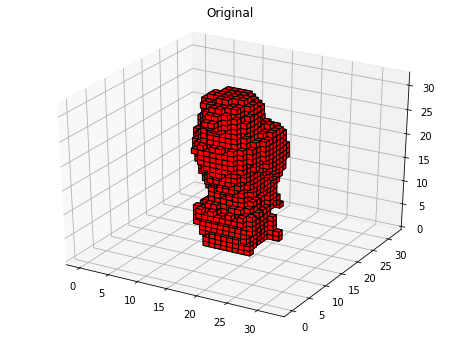

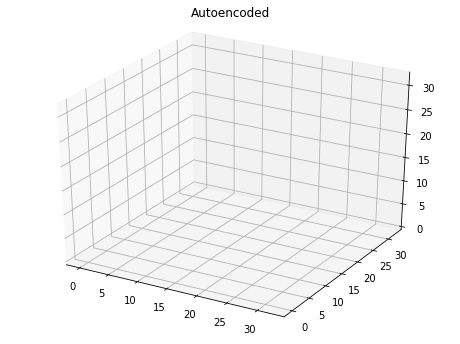

Epoch: 36, Batch: 0, Elapsed time: 4.87 mins
DEBUG_OP "max clipped_output": 0.9999483823776245
DEBUG_OP "min clipped_output": 2.9661794542334974e-05
DEBUG_OP "mean clipped_output": 0.32086437940597534
	KL Divergence = 741.3316040039062, Reconstruction Loss = 339.3638916015625
Epoch: 36, Batch: 1, Elapsed time: 4.88 mins
DEBUG_OP "max clipped_output": 0.9999456405639648
DEBUG_OP "min clipped_output": 4.344024637248367e-05
DEBUG_OP "mean clipped_output": 0.31869861483573914
	KL Divergence = 809.2708129882812, Reconstruction Loss = 353.116943359375
Epoch: 36, Batch: 2, Elapsed time: 4.90 mins
DEBUG_OP "max clipped_output": 0.9998881816864014
DEBUG_OP "min clipped_output": 4.305865877540782e-05
DEBUG_OP "mean clipped_output": 0.3251137137413025
	KL Divergence = 819.6761474609375, Reconstruction Loss = 349.2481384277344
Epoch: 36, Batch: 3, Elapsed time: 4.91 mins
DEBUG_OP "max clipped_output": 0.9999535083770752
DEBUG_OP "min clipped_output": 2.1358735466492362e-05
DEBUG_OP "mean clipped_o

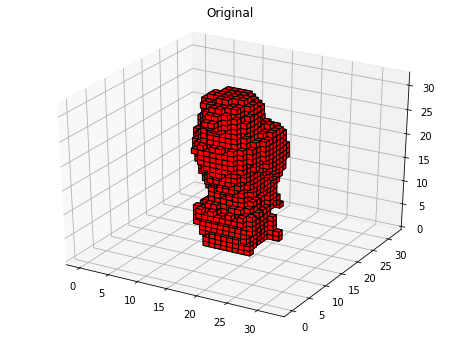

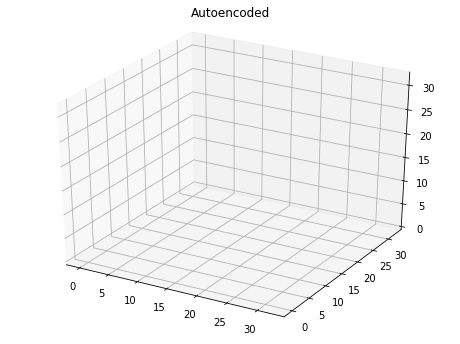

Epoch: 37, Batch: 0, Elapsed time: 5.01 mins
DEBUG_OP "max clipped_output": 0.9999686479568481
DEBUG_OP "min clipped_output": 1.4384191672434099e-05
DEBUG_OP "mean clipped_output": 0.3240373730659485
	KL Divergence = 920.5091552734375, Reconstruction Loss = 328.4044189453125
Epoch: 37, Batch: 1, Elapsed time: 5.02 mins
DEBUG_OP "max clipped_output": 0.9999129772186279
DEBUG_OP "min clipped_output": 2.739388946793042e-05
DEBUG_OP "mean clipped_output": 0.3193877041339874
	KL Divergence = 863.8099975585938, Reconstruction Loss = 340.9827880859375
Epoch: 37, Batch: 2, Elapsed time: 5.03 mins
DEBUG_OP "max clipped_output": 0.9999476671218872
DEBUG_OP "min clipped_output": 2.7552501705940813e-05
DEBUG_OP "mean clipped_output": 0.3256833553314209
	KL Divergence = 824.3426513671875, Reconstruction Loss = 337.4549560546875
Epoch: 37, Batch: 3, Elapsed time: 5.05 mins
DEBUG_OP "max clipped_output": 0.9999802112579346
DEBUG_OP "min clipped_output": 3.0370454624062404e-05
DEBUG_OP "mean clipped_o

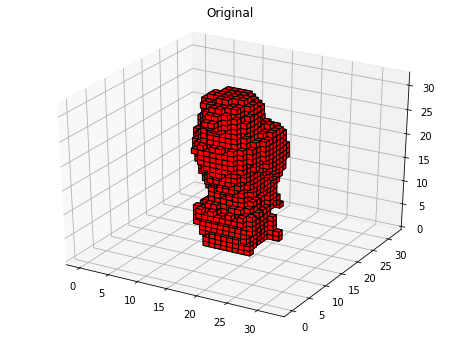

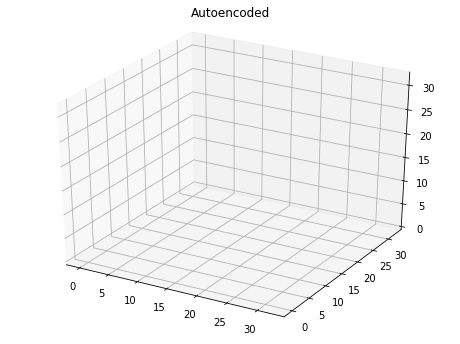

Epoch: 38, Batch: 0, Elapsed time: 5.15 mins
DEBUG_OP "max clipped_output": 0.9999696016311646
DEBUG_OP "min clipped_output": 2.1034265955677256e-05
DEBUG_OP "mean clipped_output": 0.3178431987762451
	KL Divergence = 743.2262573242188, Reconstruction Loss = 343.343994140625
Epoch: 38, Batch: 1, Elapsed time: 5.16 mins
DEBUG_OP "max clipped_output": 0.9999567270278931
DEBUG_OP "min clipped_output": 3.0510434953612275e-05
DEBUG_OP "mean clipped_output": 0.3146083652973175
	KL Divergence = 928.541259765625, Reconstruction Loss = 351.7073974609375
Epoch: 38, Batch: 2, Elapsed time: 5.17 mins
DEBUG_OP "max clipped_output": 0.9999247789382935
DEBUG_OP "min clipped_output": 5.507099558599293e-05
DEBUG_OP "mean clipped_output": 0.32511597871780396
	KL Divergence = 892.6357421875, Reconstruction Loss = 335.5905456542969
Epoch: 38, Batch: 3, Elapsed time: 5.19 mins
DEBUG_OP "max clipped_output": 0.999992847442627
DEBUG_OP "min clipped_output": 1.528656321170274e-05
DEBUG_OP "mean clipped_output"

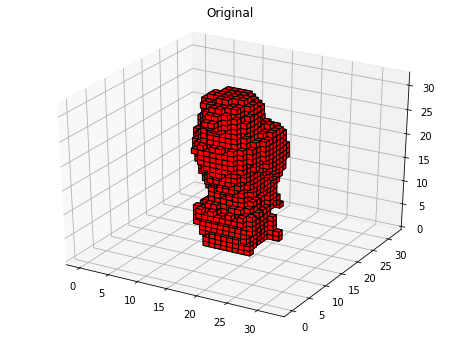

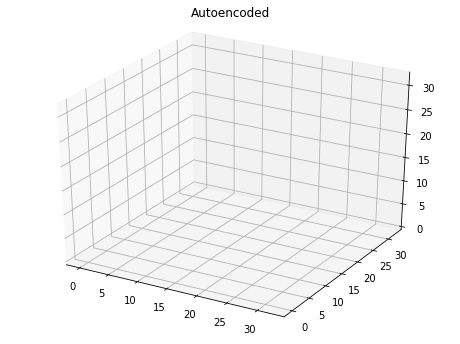

Epoch: 39, Batch: 0, Elapsed time: 5.28 mins
DEBUG_OP "max clipped_output": 0.9999325275421143
DEBUG_OP "min clipped_output": 1.3054337614448741e-05
DEBUG_OP "mean clipped_output": 0.3228178322315216
	KL Divergence = 714.3418579101562, Reconstruction Loss = 338.6493225097656
Epoch: 39, Batch: 1, Elapsed time: 5.29 mins
DEBUG_OP "max clipped_output": 0.9999468326568604
DEBUG_OP "min clipped_output": 2.283152389281895e-05
DEBUG_OP "mean clipped_output": 0.31424710154533386
	KL Divergence = 850.2827758789062, Reconstruction Loss = 343.7515563964844
Epoch: 39, Batch: 2, Elapsed time: 5.31 mins
DEBUG_OP "max clipped_output": 0.9999195337295532
DEBUG_OP "min clipped_output": 2.7307554773869924e-05
DEBUG_OP "mean clipped_output": 0.3237382769584656
	KL Divergence = 865.6851806640625, Reconstruction Loss = 332.73248291015625
Epoch: 39, Batch: 3, Elapsed time: 5.32 mins
DEBUG_OP "max clipped_output": 0.9999479055404663
DEBUG_OP "min clipped_output": 3.712990655913018e-05
DEBUG_OP "mean clipped_

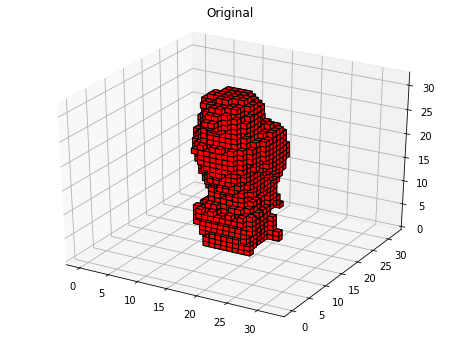

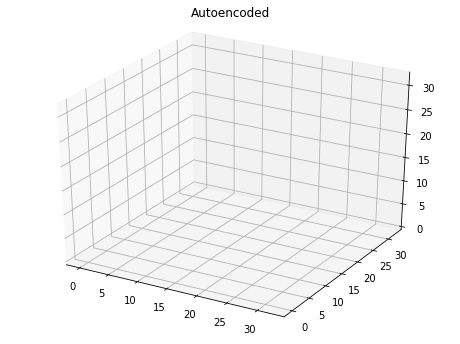

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-39.ckpt
Epoch: 40, Batch: 0, Elapsed time: 5.42 mins
DEBUG_OP "max clipped_output": 0.9999703168869019
DEBUG_OP "min clipped_output": 9.030834917211905e-06
DEBUG_OP "mean clipped_output": 0.3152667284011841
	KL Divergence = 817.6036376953125, Reconstruction Loss = 320.7882995605469
Epoch: 40, Batch: 1, Elapsed time: 5.43 mins
DEBUG_OP "max clipped_output": 0.9999374151229858
DEBUG_OP "min clipped_output": 2.5127774279098958e-05
DEBUG_OP "mean clipped_output": 0.30803972482681274
	KL Divergence = 869.9903564453125, Reconstruction Loss = 327.4540100097656
Epoch: 40, Batch: 2, Elapsed time: 5.45 mins
DEBUG_OP "max clipped_output": 0.9999395608901978
DEBUG_OP "min clipped_output": 3.342097261338495e-05
DEBUG_OP "mean clipped_output": 0.3178269863128662
	KL Divergence = 826.0191040039062, Reconstruction Loss = 314.48187255859375
Epoch: 40, Batch: 3, Elapsed time: 5.46 mins
DEBUG_OP "max clipped_output": 0.9

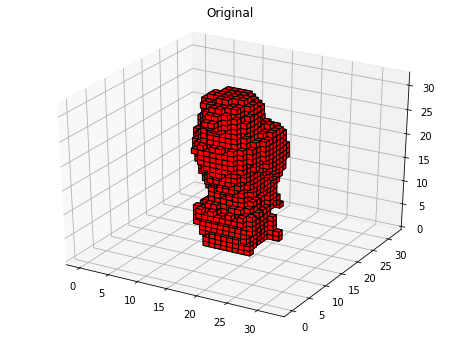

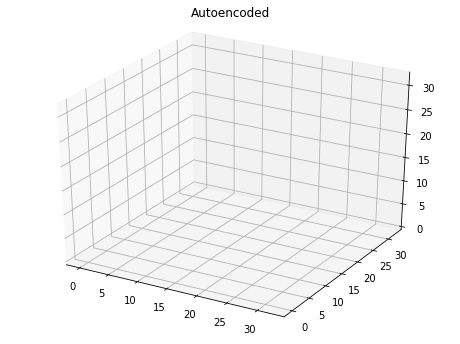

Epoch: 41, Batch: 0, Elapsed time: 5.55 mins
DEBUG_OP "max clipped_output": 0.9999535083770752
DEBUG_OP "min clipped_output": 1.713493838906288e-05
DEBUG_OP "mean clipped_output": 0.3151658773422241
	KL Divergence = 769.0810546875, Reconstruction Loss = 321.22613525390625
Epoch: 41, Batch: 1, Elapsed time: 5.57 mins
DEBUG_OP "max clipped_output": 0.9999618530273438
DEBUG_OP "min clipped_output": 1.1301272024866194e-05
DEBUG_OP "mean clipped_output": 0.3075335621833801
	KL Divergence = 871.68310546875, Reconstruction Loss = 329.869384765625
Epoch: 41, Batch: 2, Elapsed time: 5.58 mins
DEBUG_OP "max clipped_output": 0.999948263168335
DEBUG_OP "min clipped_output": 2.3443149984814227e-05
DEBUG_OP "mean clipped_output": 0.31434646248817444
	KL Divergence = 833.040283203125, Reconstruction Loss = 339.9549560546875
Epoch: 41, Batch: 3, Elapsed time: 5.59 mins
DEBUG_OP "max clipped_output": 0.9999678134918213
DEBUG_OP "min clipped_output": 1.1829842151200864e-05
DEBUG_OP "mean clipped_output"

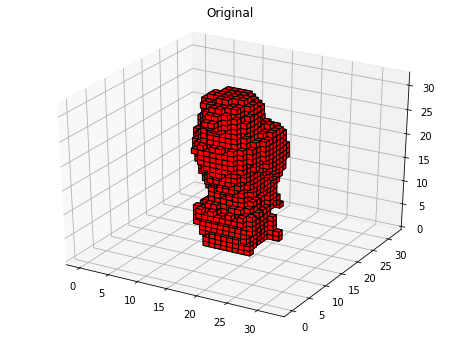

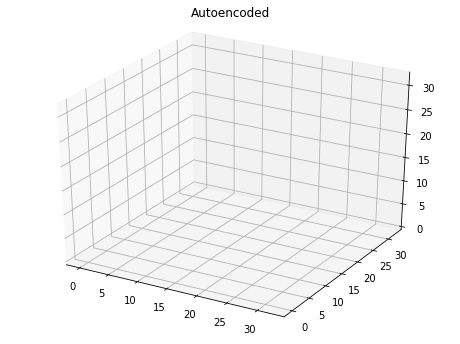

Epoch: 42, Batch: 0, Elapsed time: 5.69 mins
DEBUG_OP "max clipped_output": 0.9999665021896362
DEBUG_OP "min clipped_output": 7.5978423410560936e-06
DEBUG_OP "mean clipped_output": 0.3074321150779724
	KL Divergence = 824.537841796875, Reconstruction Loss = 310.4690856933594
Epoch: 42, Batch: 1, Elapsed time: 5.70 mins
DEBUG_OP "max clipped_output": 0.9999736547470093
DEBUG_OP "min clipped_output": 1.3553607459471095e-05
DEBUG_OP "mean clipped_output": 0.30369099974632263
	KL Divergence = 797.7396850585938, Reconstruction Loss = 332.7833251953125
Epoch: 42, Batch: 2, Elapsed time: 5.72 mins
DEBUG_OP "max clipped_output": 0.9999351501464844
DEBUG_OP "min clipped_output": 1.775577948137652e-05
DEBUG_OP "mean clipped_output": 0.3080044388771057
	KL Divergence = 791.2125244140625, Reconstruction Loss = 347.5030517578125
Epoch: 42, Batch: 3, Elapsed time: 5.73 mins
DEBUG_OP "max clipped_output": 0.999951958656311
DEBUG_OP "min clipped_output": 9.129204045166261e-06
DEBUG_OP "mean clipped_out

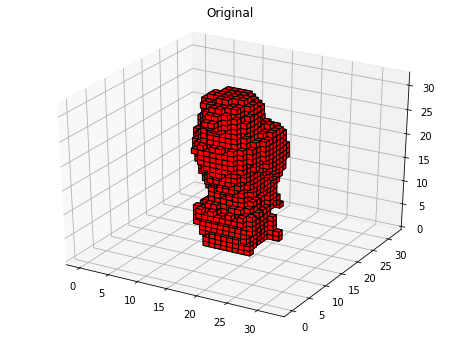

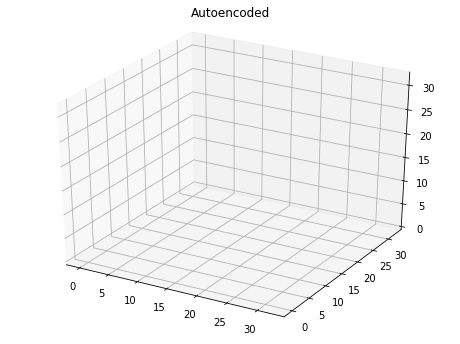

Epoch: 43, Batch: 0, Elapsed time: 5.83 mins
DEBUG_OP "max clipped_output": 0.999947190284729
DEBUG_OP "min clipped_output": 6.388051588146482e-06
DEBUG_OP "mean clipped_output": 0.31467148661613464
	KL Divergence = 736.7626953125, Reconstruction Loss = 335.322021484375
Epoch: 43, Batch: 1, Elapsed time: 5.84 mins
DEBUG_OP "max clipped_output": 0.9999527931213379
DEBUG_OP "min clipped_output": 1.7238080545212142e-05
DEBUG_OP "mean clipped_output": 0.30762147903442383
	KL Divergence = 826.8238525390625, Reconstruction Loss = 342.45263671875
Epoch: 43, Batch: 2, Elapsed time: 5.85 mins
DEBUG_OP "max clipped_output": 0.9998487234115601
DEBUG_OP "min clipped_output": 3.845287938020192e-05
DEBUG_OP "mean clipped_output": 0.3177337050437927
	KL Divergence = 877.4520263671875, Reconstruction Loss = 332.2783203125
Epoch: 43, Batch: 3, Elapsed time: 5.87 mins
DEBUG_OP "max clipped_output": 0.999984622001648
DEBUG_OP "min clipped_output": 1.4904898307577241e-05
DEBUG_OP "mean clipped_output": 0.

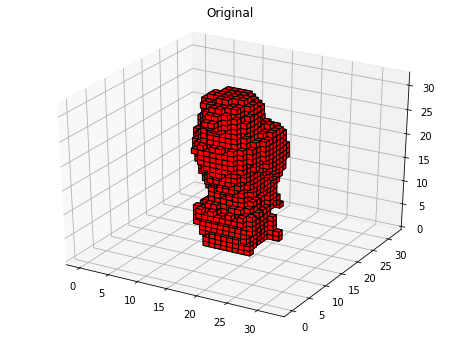

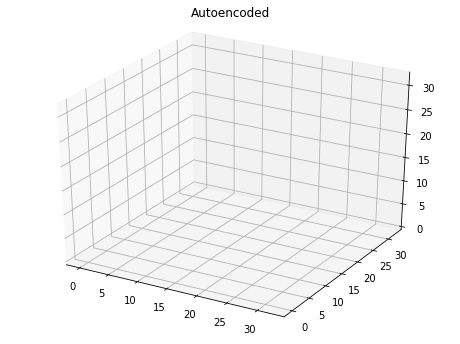

Epoch: 44, Batch: 0, Elapsed time: 5.96 mins
DEBUG_OP "max clipped_output": 0.9998819828033447
DEBUG_OP "min clipped_output": 7.799566446919926e-06
DEBUG_OP "mean clipped_output": 0.3153611123561859
	KL Divergence = 881.9437255859375, Reconstruction Loss = 311.3937683105469
Epoch: 44, Batch: 1, Elapsed time: 5.97 mins
DEBUG_OP "max clipped_output": 0.9999561309814453
DEBUG_OP "min clipped_output": 2.2229260139283724e-05
DEBUG_OP "mean clipped_output": 0.2982929050922394
	KL Divergence = 841.687255859375, Reconstruction Loss = 323.4183044433594
Epoch: 44, Batch: 2, Elapsed time: 5.99 mins
DEBUG_OP "max clipped_output": 0.9999303817749023
DEBUG_OP "min clipped_output": 1.9529592464095913e-05
DEBUG_OP "mean clipped_output": 0.31260135769844055
	KL Divergence = 843.424072265625, Reconstruction Loss = 323.96685791015625
Epoch: 44, Batch: 3, Elapsed time: 6.00 mins
DEBUG_OP "max clipped_output": 0.999987006187439
DEBUG_OP "min clipped_output": 7.444906714226818e-06
DEBUG_OP "mean clipped_out

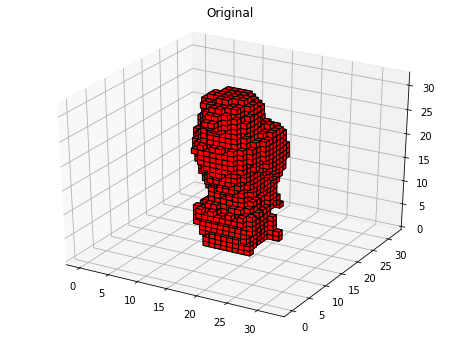

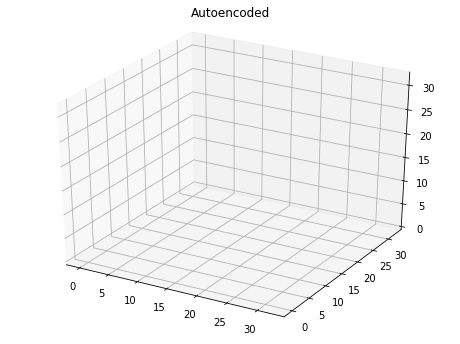

Epoch: 45, Batch: 0, Elapsed time: 6.10 mins
DEBUG_OP "max clipped_output": 0.9999476671218872
DEBUG_OP "min clipped_output": 1.5737487046862952e-05
DEBUG_OP "mean clipped_output": 0.30568838119506836
	KL Divergence = 844.3406372070312, Reconstruction Loss = 301.00152587890625
Epoch: 45, Batch: 1, Elapsed time: 6.11 mins
DEBUG_OP "max clipped_output": 0.9999581575393677
DEBUG_OP "min clipped_output": 2.1293188183335587e-05
DEBUG_OP "mean clipped_output": 0.29615819454193115
	KL Divergence = 806.792724609375, Reconstruction Loss = 337.8290710449219
Epoch: 45, Batch: 2, Elapsed time: 6.13 mins
DEBUG_OP "max clipped_output": 0.9999686479568481
DEBUG_OP "min clipped_output": 2.070583650493063e-05
DEBUG_OP "mean clipped_output": 0.30901551246643066
	KL Divergence = 885.8720092773438, Reconstruction Loss = 322.53082275390625
Epoch: 45, Batch: 3, Elapsed time: 6.14 mins
DEBUG_OP "max clipped_output": 0.9999661445617676
DEBUG_OP "min clipped_output": 1.2426916327967774e-05
DEBUG_OP "mean clipp

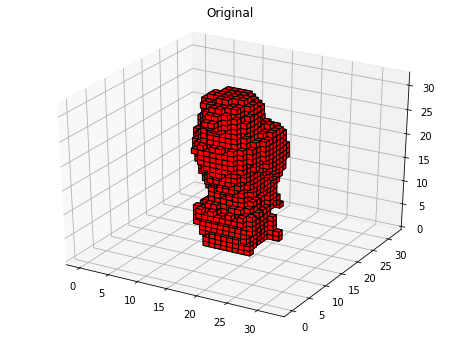

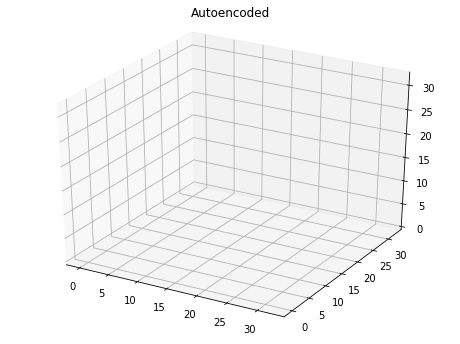

Epoch: 46, Batch: 0, Elapsed time: 6.23 mins
DEBUG_OP "max clipped_output": 0.999976396560669
DEBUG_OP "min clipped_output": 5.412888185674092e-06
DEBUG_OP "mean clipped_output": 0.3069826066493988
	KL Divergence = 744.9915771484375, Reconstruction Loss = 319.6600646972656
Epoch: 46, Batch: 1, Elapsed time: 6.24 mins
DEBUG_OP "max clipped_output": 0.9999809265136719
DEBUG_OP "min clipped_output": 1.1017793440259993e-05
DEBUG_OP "mean clipped_output": 0.29908373951911926
	KL Divergence = 805.2557373046875, Reconstruction Loss = 317.4449462890625
Epoch: 46, Batch: 2, Elapsed time: 6.26 mins
DEBUG_OP "max clipped_output": 0.9999479055404663
DEBUG_OP "min clipped_output": 1.6469832189613953e-05
DEBUG_OP "mean clipped_output": 0.3087323307991028
	KL Divergence = 834.5384521484375, Reconstruction Loss = 334.1617736816406
Epoch: 46, Batch: 3, Elapsed time: 6.27 mins
DEBUG_OP "max clipped_output": 0.9999687671661377
DEBUG_OP "min clipped_output": 1.1433156032580882e-05
DEBUG_OP "mean clipped_o

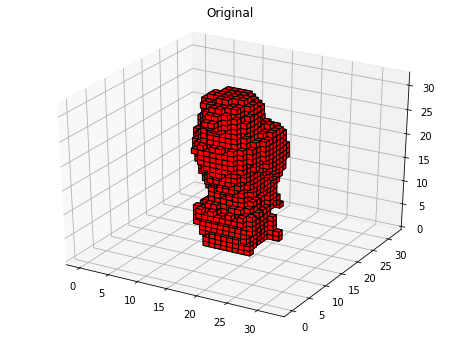

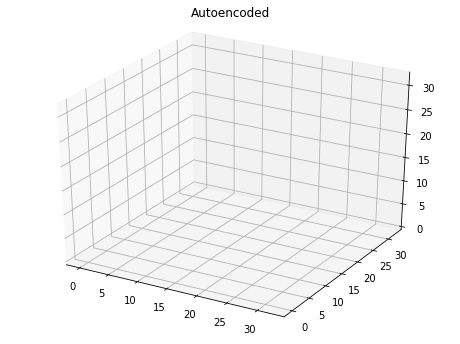

Epoch: 47, Batch: 0, Elapsed time: 6.37 mins
DEBUG_OP "max clipped_output": 0.9999699592590332
DEBUG_OP "min clipped_output": 8.156182047969196e-06
DEBUG_OP "mean clipped_output": 0.3059999346733093
	KL Divergence = 782.0908203125, Reconstruction Loss = 314.6512145996094
Epoch: 47, Batch: 1, Elapsed time: 6.38 mins
DEBUG_OP "max clipped_output": 0.9999771118164062
DEBUG_OP "min clipped_output": 9.168526958092116e-06
DEBUG_OP "mean clipped_output": 0.2964276075363159
	KL Divergence = 874.0755615234375, Reconstruction Loss = 332.87799072265625
Epoch: 47, Batch: 2, Elapsed time: 6.39 mins
DEBUG_OP "max clipped_output": 0.9999387264251709
DEBUG_OP "min clipped_output": 1.4565047422365751e-05
DEBUG_OP "mean clipped_output": 0.3050195574760437
	KL Divergence = 965.59619140625, Reconstruction Loss = 307.2330322265625
Epoch: 47, Batch: 3, Elapsed time: 6.41 mins
DEBUG_OP "max clipped_output": 0.999972939491272
DEBUG_OP "min clipped_output": 1.204080672323471e-05
DEBUG_OP "mean clipped_output":

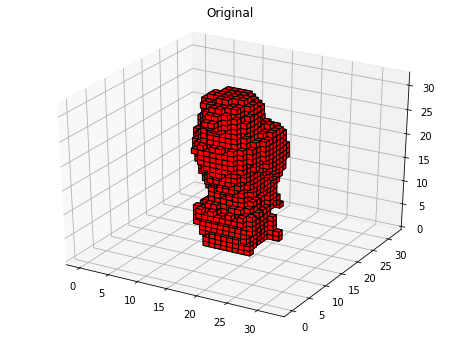

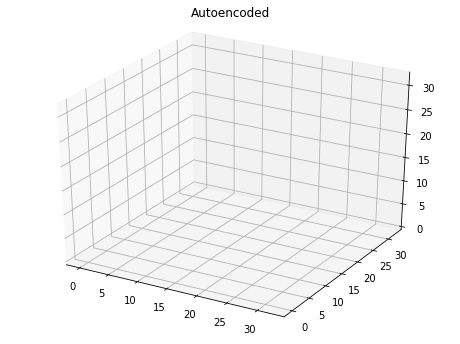

Epoch: 48, Batch: 0, Elapsed time: 6.50 mins
DEBUG_OP "max clipped_output": 0.999964714050293
DEBUG_OP "min clipped_output": 1.1400231414882e-05
DEBUG_OP "mean clipped_output": 0.29839229583740234
	KL Divergence = 778.2091064453125, Reconstruction Loss = 293.723388671875
Epoch: 48, Batch: 1, Elapsed time: 6.51 mins
DEBUG_OP "max clipped_output": 0.9999685287475586
DEBUG_OP "min clipped_output": 1.4051536709303036e-05
DEBUG_OP "mean clipped_output": 0.29151690006256104
	KL Divergence = 759.5418090820312, Reconstruction Loss = 330.1350402832031
Epoch: 48, Batch: 2, Elapsed time: 6.53 mins
DEBUG_OP "max clipped_output": 0.9999523162841797
DEBUG_OP "min clipped_output": 1.5735431588836946e-05
DEBUG_OP "mean clipped_output": 0.30526769161224365
	KL Divergence = 906.1133422851562, Reconstruction Loss = 330.614501953125
Epoch: 48, Batch: 3, Elapsed time: 6.54 mins
DEBUG_OP "max clipped_output": 0.9999681711196899
DEBUG_OP "min clipped_output": 6.210673745954409e-06
DEBUG_OP "mean clipped_outp

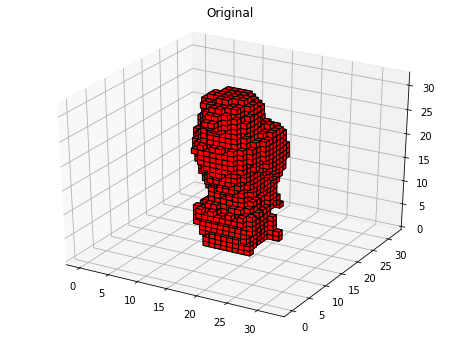

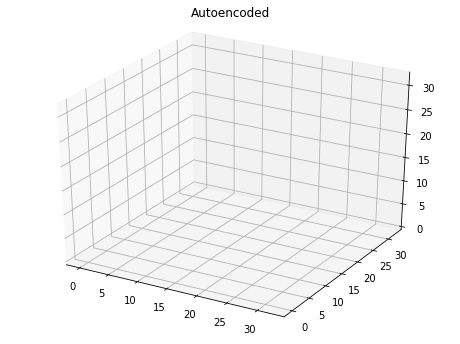

Epoch: 49, Batch: 0, Elapsed time: 6.64 mins
DEBUG_OP "max clipped_output": 0.9999868869781494
DEBUG_OP "min clipped_output": 5.8898426686937455e-06
DEBUG_OP "mean clipped_output": 0.30261608958244324
	KL Divergence = 698.863037109375, Reconstruction Loss = 307.5474853515625
Epoch: 49, Batch: 1, Elapsed time: 6.65 mins
DEBUG_OP "max clipped_output": 0.9999756813049316
DEBUG_OP "min clipped_output": 1.330470149696339e-05
DEBUG_OP "mean clipped_output": 0.2948642671108246
	KL Divergence = 719.548583984375, Reconstruction Loss = 322.5481262207031
Epoch: 49, Batch: 2, Elapsed time: 6.67 mins
DEBUG_OP "max clipped_output": 0.9999605417251587
DEBUG_OP "min clipped_output": 7.705943971814122e-06
DEBUG_OP "mean clipped_output": 0.3059961199760437
	KL Divergence = 788.341552734375, Reconstruction Loss = 313.56719970703125
Epoch: 49, Batch: 3, Elapsed time: 6.68 mins
DEBUG_OP "max clipped_output": 0.9999732971191406
DEBUG_OP "min clipped_output": 7.953967724461108e-06
DEBUG_OP "mean clipped_outp

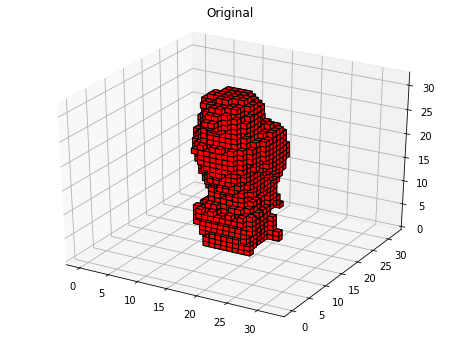

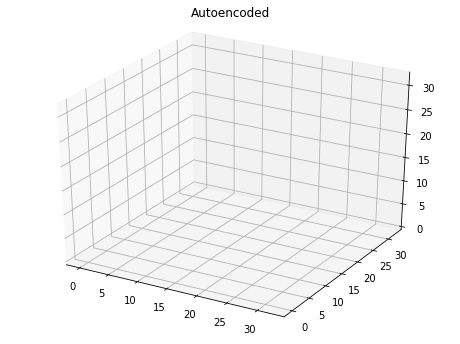

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-49.ckpt


In [31]:
tf.reset_default_graph()

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=100,
                                 learning_rate=0.0001,
                                 keep_prob=1.0,
                                 kl_div_loss_weight=1,
                                 recon_loss_weight=1e4,
                                 verbose=True,
                                 debug=True)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=50, input_repeats=1, display_step=1, save_step=10,
             viz_data=training_example)
except Exception as exc:
    vae.close()
    raise(exc)

DEBUG_OP "max clipped_output": 0.18866020441055298
DEBUG_OP "min clipped_output": 0.011335152201354504
DEBUG_OP "mean clipped_output": 0.044964633882045746


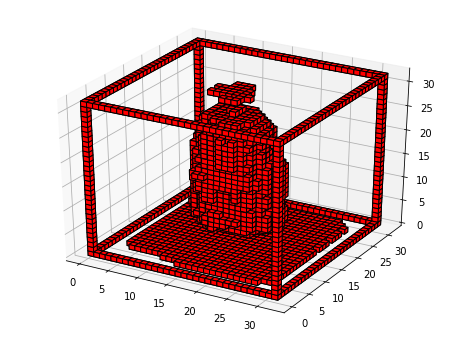

In [36]:
vox_data = thingi.get_voxels(
    VOXELS_DIM,
    stl_file=thingi.get_stl_path(stl_id=126660),
    shape=[-1, VOXELS_DIM, VOXELS_DIM, VOXELS_DIM, 1])
recon = vae.reconstruct(vox_data)
recon = np.reshape(recon, [VOXELS_DIM, VOXELS_DIM, VOXELS_DIM])
recon = recon > 0.065
plot_voxels(recon)